# Advanced Regression model with regularization: Market Entry case in Australia


#### Problem statement

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:

- Which variables are significant in predicting the price of a house, and 
- How well those variables describe the price of a house ?
- Also, determine the optimal value of lambda for ridge and lasso regression.


#### Business Goal 

It is required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

# Summary of Steps


The solution is divided into the following sections:

# Data Exploration : Understand the given data set

Let's first have a look at the dataset and understand the size, attribute names etc.

In [375]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [376]:
# reading the dataset
aus_house = pd.read_csv("Australian market.csv")

In [377]:
# summary of the dataset: 1460 rows, 81 columns, no null values
print(aus_house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [378]:
# head
aus_house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

## Understanding the Data Dictionary

#### Data Dictionary inputs

- Went through the data dictionary provided. 
- Prepared a list of numerical columns and categorical columns. 
- Will make sure that the Dtype is properly assigned to these columns
- The following columns contain time information we will be adding these under categorical list. Since these columns contain only one information, hence we don't have to extract month/yearly information. 
    - YearBuilt: contains only year information
    - YearRemodAdd: contains only year information
    - GarageYrBlt: contains only year information
    - MoSold: contains only month information
    - YrSold: contains only year information

# Data Wrangling : Prepare a clean data set

In [379]:
# Numerical columns
numerical_columns = ['Id','BedroomAbvGr', 'KitchenAbvGr','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']

# Categorical columns
categorical_columns = ['MSSubClass','MSZoning', 'Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

print('There are ' + str(len(numerical_columns)) + ' columns which contain numerical variables and there are ' + str(len(categorical_columns)) + ' which contain categorical variables. Total = ' + str(len(numerical_columns) + len(categorical_columns)))

There are 30 columns which contain numerical variables and there are 51 which contain categorical variables. Total = 81


#### Observations

Since our objective is to find out which variables are significant in predicting the price of a house, and how well those variables describe the price of a house. We can say that 
- Dependent variable = SalePrice
- Independent variables = others 

Action Items

- Change datatype to object for categorical columns and float64 for numerical columns
- Remove 'Id' column - not required in the analyis


In [380]:
# change data type to object for the following columns
aus_house[categorical_columns] = aus_house[categorical_columns].astype('object')
aus_house[numerical_columns] = aus_house[numerical_columns].astype('float64')


In [381]:
# Remove 'Id' column from the data set
aus_house_df = aus_house.drop(['Id'], axis = 1)

#### Check for missing and NA values

In [382]:
# Missing value in the data frame

import pandas as pd

# Check for missing values
missing_values = aus_house_df.isnull().sum()

# Filter columns with missing values
missing_values = missing_values[missing_values > 0]

# If there are missing values, create a DataFrame to store the missing value information
if not missing_values.empty:
    missing_info = pd.DataFrame(missing_values, columns=['missing_count'])
    missing_info['missing_percentage'] = (missing_info['missing_count'] / len(aus_house_df)) * 100

    # Sort the DataFrame based on missing_percentage in descending order
    missing_info = missing_info.sort_values(by='missing_percentage', ascending=False)

    # Create a new DataFrame to store missing information separately
    missing_info_separate = missing_info.copy()

    # Display the result
    print(missing_info_separate)
else:
    print("No missing values in the DataFrame.")


              missing_count  missing_percentage
PoolQC                 1453           99.520548
MiscFeature            1406           96.301370
Alley                  1369           93.767123
Fence                  1179           80.753425
FireplaceQu             690           47.260274
LotFrontage             259           17.739726
GarageType               81            5.547945
GarageYrBlt              81            5.547945
GarageFinish             81            5.547945
GarageQual               81            5.547945
GarageCond               81            5.547945
BsmtExposure             38            2.602740
BsmtFinType2             38            2.602740
BsmtFinType1             37            2.534247
BsmtCond                 37            2.534247
BsmtQual                 37            2.534247
MasVnrArea                8            0.547945
MasVnrType                8            0.547945
Electrical                1            0.068493


#### Observation/s

- Based on the missing percentage 
    - Remvoe these columns 'PoolQC', 'MiscFeature', 'Alley', 'Fence',
    
- FireplaceQu: Fireplace quality is of the following types.

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
    - Impute 'No Fireplace' in place of 'NA'
    
- LotFrontage: Linear feet of street connected to property - Since this also improves the accessibility to the property and also one can use this for commercial activity due to well connectivity to street. We will not delete this column. 
    - We will impute '0' for 'NA' values

- GarageType: Garage location is of the following types
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
    - Impute 'No Garage' in place of 'NA'
- We can observe that the 81 missing values in 'GarageFinish', 'GarageQual', 'GarageCond'  are due to No Garage and hence 
    - Impute 'No Garage' in place of 'NA' for the 'GarageFinish', 'GarageQual', 'GarageCond' columns
- For GarageYrBlt impute '0' since we don't have any garage for these houses.

- BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
    - Impute 'No Basement' for 'NA' values 
- Similarly for Impute 'No Basement' for 'NA' values in the following columns 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual'.

- MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	- Impute 'None' for 'NA' values in MasVnrType
    
- MasVnrArea: Masonry veneer area in square feet
    - Impute '0' for 'NA' values in  MasVnrArea
- Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
    - Remove the 'NA' row.

In [383]:
# Columns to remove
columns_to_remove1 = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']

# Remove specified columns
aus_house_df = aus_house_df.drop(columns=columns_to_remove1)

In [384]:
# Impute 'No Fireplace' in place of 'NA' in the 'FireplaceQu' column
aus_house_df['FireplaceQu'] = aus_house_df['FireplaceQu'].fillna('No Fireplace')

In [385]:
# Impute '0' in place of 'NA' in the 'LotFrontage' column
aus_house_df['LotFrontage'] = aus_house_df['LotFrontage'].fillna(0)

In [386]:
# Columns to impute
columns_to_impute1 = ['GarageType','GarageFinish', 'GarageQual', 'GarageCond']

# Impute 'No Garage' in place of 'NA' for specified columns
aus_house_df[columns_to_impute1] = aus_house_df[columns_to_impute1].fillna('No Garage')

# Impute '0' in place of 'NA' in the 'GarageYrBlt' column
aus_house_df['GarageYrBlt'] = aus_house_df['GarageYrBlt'].fillna(0)


In [387]:
# Columns to impute
columns_to_impute2 = ['BsmtExposure','BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual']

# Impute 'No Basement' in place of 'NA' for specified columns
aus_house_df[columns_to_impute2] = aus_house_df[columns_to_impute2].fillna('No Basement')

In [388]:
# Impute 'None' in place of 'NA' in the 'MasVnrType' column
aus_house_df['MasVnrType'] = aus_house_df['MasVnrType'].fillna('None')

# Impute '0' in place of 'NA' in the 'MasVnrArea' column
aus_house_df['MasVnrArea'] = aus_house_df['MasVnrArea'].fillna(0)

In [389]:
# Find the row index where 'Electrical' is 'NA'
na_electrical_rows = aus_house_df[aus_house_df['Electrical'].isna()].index

# Drop the rows with 'NA' in the 'Electrical' column
aus_house_df = aus_house_df.drop(index=na_electrical_rows)

In [390]:
# Recheck for missing values in the data frame

import pandas as pd

# Check for missing values
missing_values = aus_house_df.isnull().sum()

# Filter columns with missing values
missing_values = missing_values[missing_values > 0]

# If there are missing values, create a DataFrame to store the missing value information
if not missing_values.empty:
    missing_info = pd.DataFrame(missing_values, columns=['missing_count'])
    missing_info['missing_percentage'] = (missing_info['missing_count'] / len(aus_house_df)) * 100

    # Sort the DataFrame based on missing_percentage in descending order
    missing_info = missing_info.sort_values(by='missing_percentage', ascending=False)

    # Create a new DataFrame to store missing information separately
    missing_info_separate = missing_info.copy()

    # Display the result
    print(missing_info_separate)
else:
    print("No missing values in the DataFrame.")


No missing values in the DataFrame.


In [391]:
# update the catecategorical_columns list 
# We have removed the following columns ['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence']

# Numerical columns
numerical_columns = ['BedroomAbvGr', 'KitchenAbvGr','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']

# Categorical columns
categorical_columns = ['MSSubClass','MSZoning', 'Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

print('There are ' + str(len(numerical_columns)) + ' columns which contain numerical variables and there are ' + str(len(categorical_columns)) + ' which contain categorical variables. Total = ' + str(len(numerical_columns) + len(categorical_columns)))

There are 29 columns which contain numerical variables and there are 47 which contain categorical variables. Total = 76


In [392]:
# get te statistical summary of all the numerical variables
aus_house_df.describe().round(2)

LotFrontage    LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
count      1459.00    1459.00     1459.00     1459.00     1459.00    1459.00   
mean         57.61   10517.36      103.19      443.94       46.58     567.37   
std          34.67    9984.67      180.77      456.11      161.37     441.99   
min           0.00    1300.00        0.00        0.00        0.00       0.00   
25%          42.00    7549.00        0.00        0.00        0.00     223.00   
50%          63.00    9477.00        0.00      384.00        0.00     479.00   
75%          79.00   11603.00      164.50      712.50        0.00     808.00   
max         313.00  215245.00     1600.00     5644.00     1474.00    2336.00   

       TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  ...  GarageCars  \
count      1459.00   1459.00   1459.00       1459.00  ...     1459.00   
mean       1057.89   1162.91    346.79          5.85  ...        1.77   
std         438.50    386.57    436.61         48.64  ...        0.75   
min           0.00    334.00      0.00          0.00  ...        0.00   
25%         796.00    882.00      0.00          0.00  ...        1.00   
50%         992.00   1088.00      0.00          0.00  ...        2.00   
75%        1298.50   1391.50    728.00          0.00  ...        2.00   
max        6110.00   4692.00   2065.00        572.00  ...        4.00   

       GarageArea  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  \
count     1459.00     1459.00      1459.00        1459.00    1459.00   
mean       473.03       94.24        46.69          21.97       3.41   
std        213.87      125.38        66.27          61.14      29.33   
min          0.00        0.00         0.00           0.00       0.00   
25%        333.00        0.00         0.00           0.00       0.00   
50%        480.00        0.00        25.00           0.00       0.00   
75%        576.00      168.00        68.00           0.00       0.00   
max       1418.00      857.00       547.00         552.00     508.00   

       ScreenPorch  PoolArea   MiscVal  SalePrice  
count      1459.00   1459.00   1459.00    1459.00  
mean         15.07      2.76     43.52  180930.39  
std          55.78     40.19    496.29   79468.96  
min           0.00      0.00      0.00   34900.00  
25%           0.00      0.00      0.00  129950.00  
50%           0.00      0.00      0.00  163000.00  
75%           0.00      0.00      0.00  214000.00  
max         480.00    738.00  15500.00  755000.00  

[8 rows x 30 columns]

# Exploratory Data Analysis

To perform linear regression, the (numeric) target variable should be linearly related to at least one another numeric variable. Let's see whether that's true in this case.

- Visual inspection : Plot Target Variable vs. Numeric Variables to observe any pattern
    - Finds variable/s for which there is no patterns
    - Drop these variable/s after deliberation
- Visual inspection : Plot Target Variable vs. Categorical Variables to observe any pattern
    - Finds variable/s for which there is no patterns
    - Drop these variable/s after deliberation

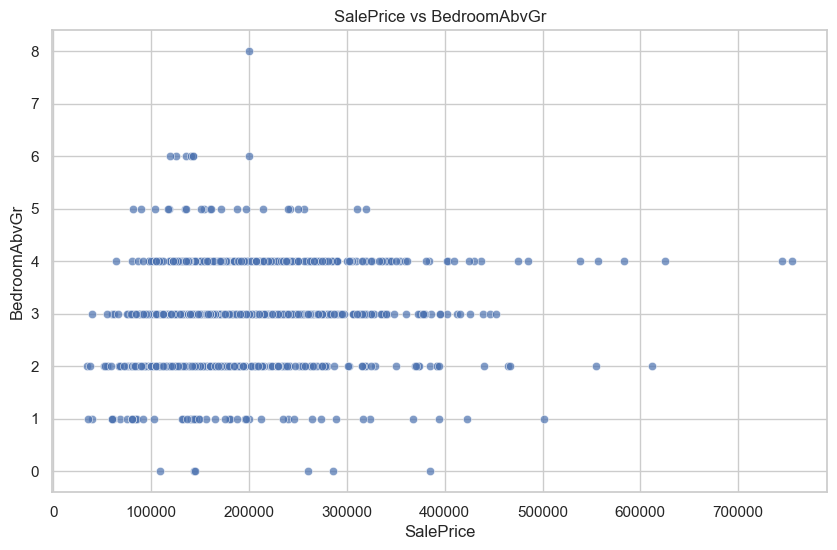

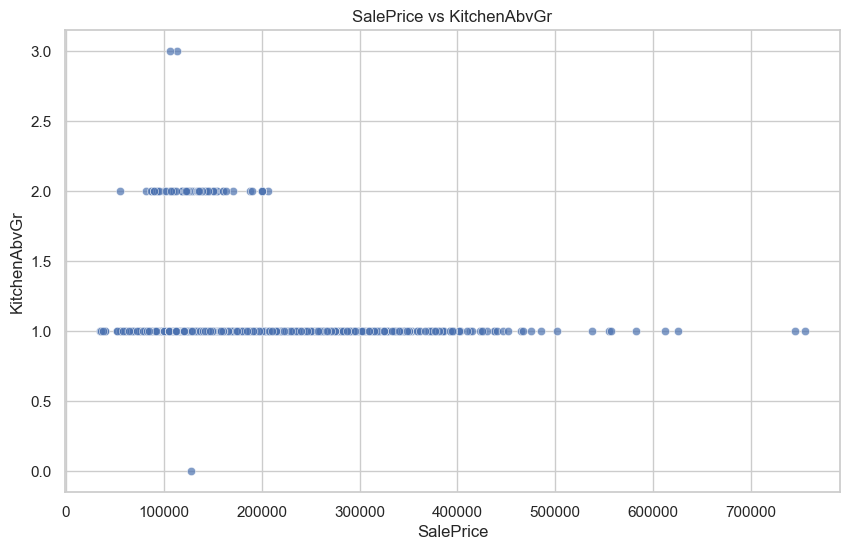

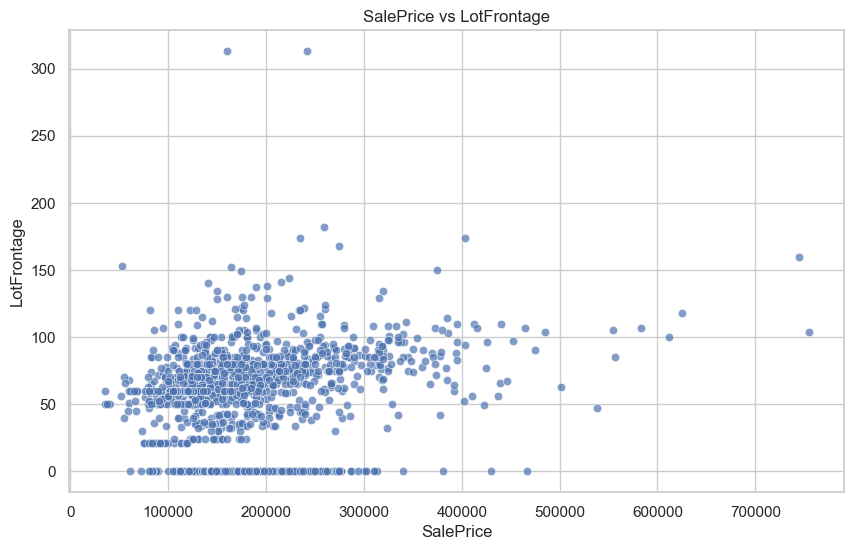

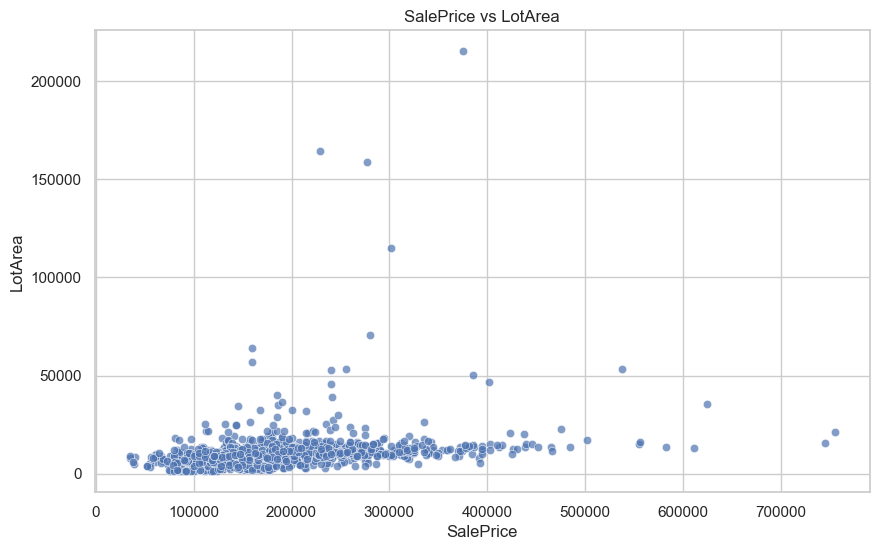

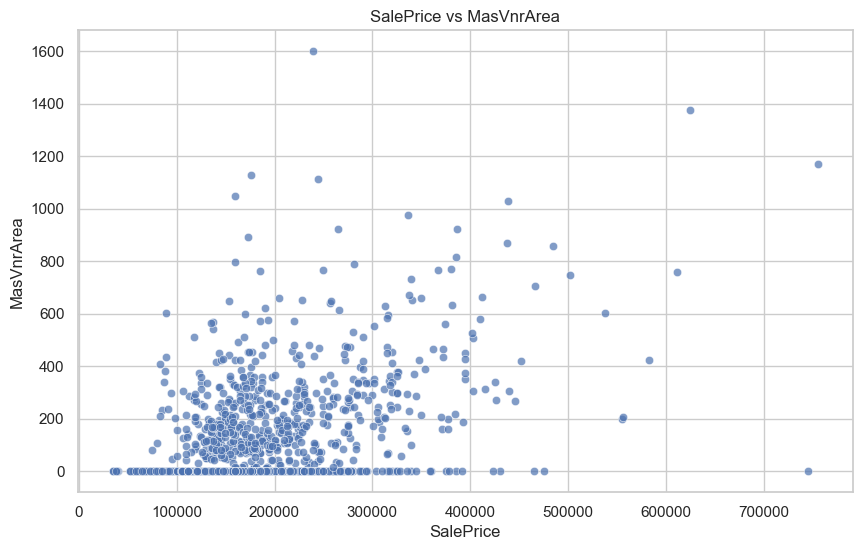

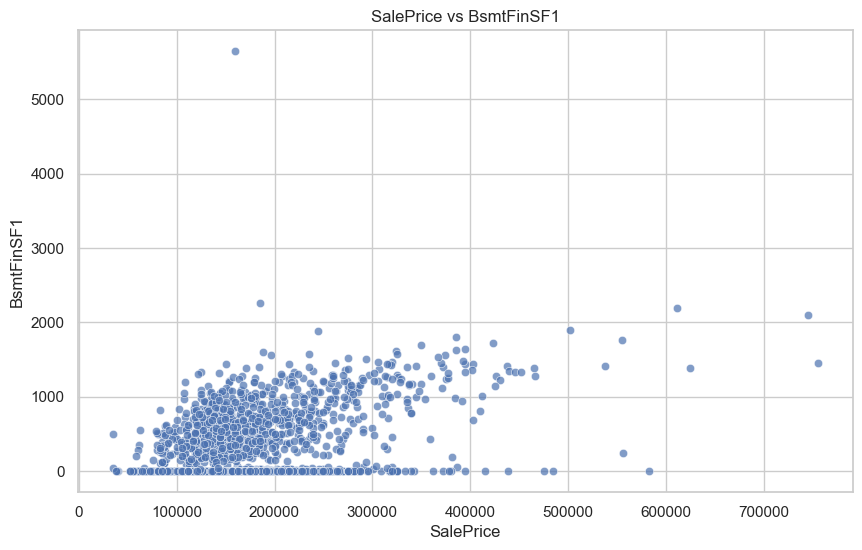

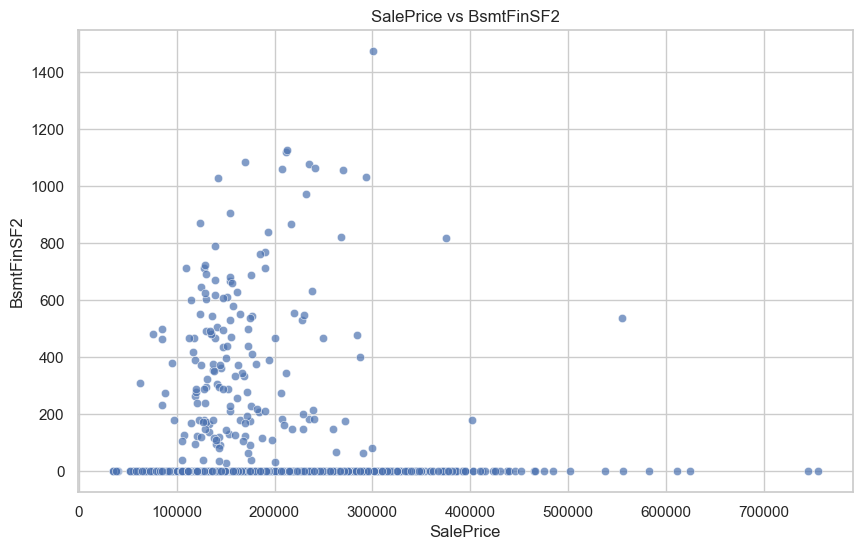

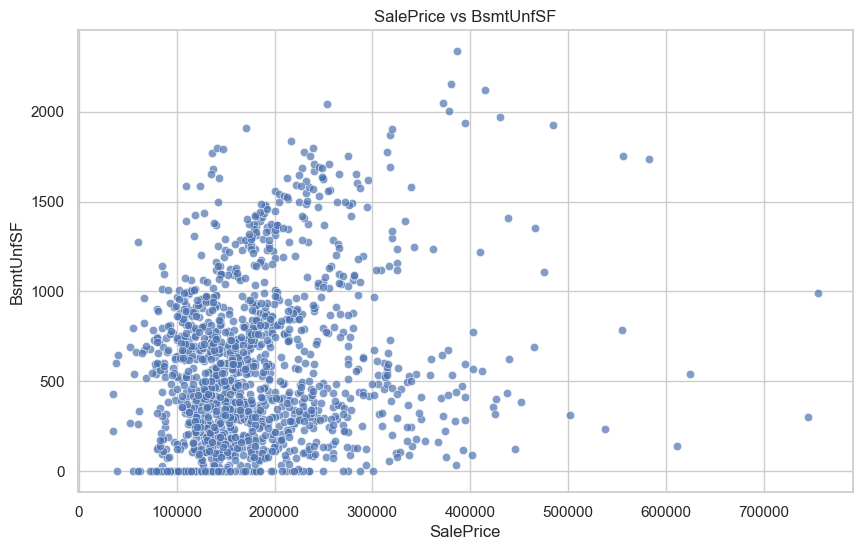

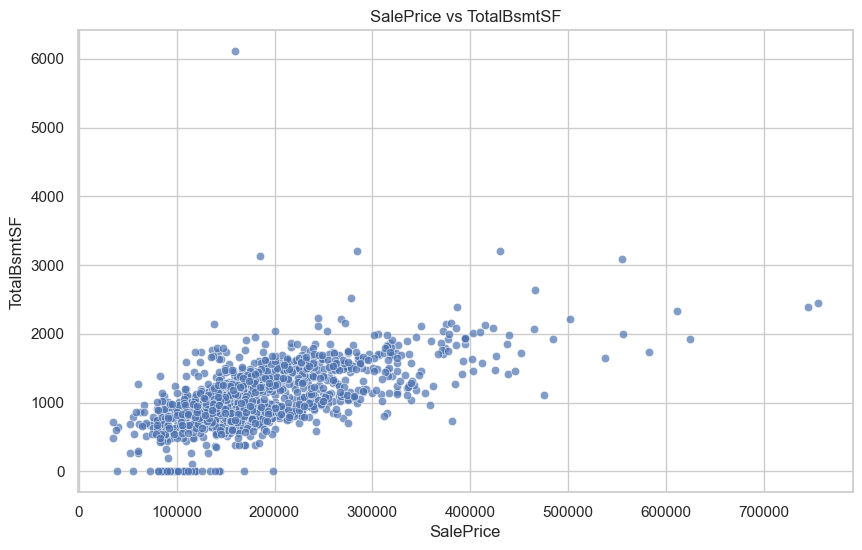

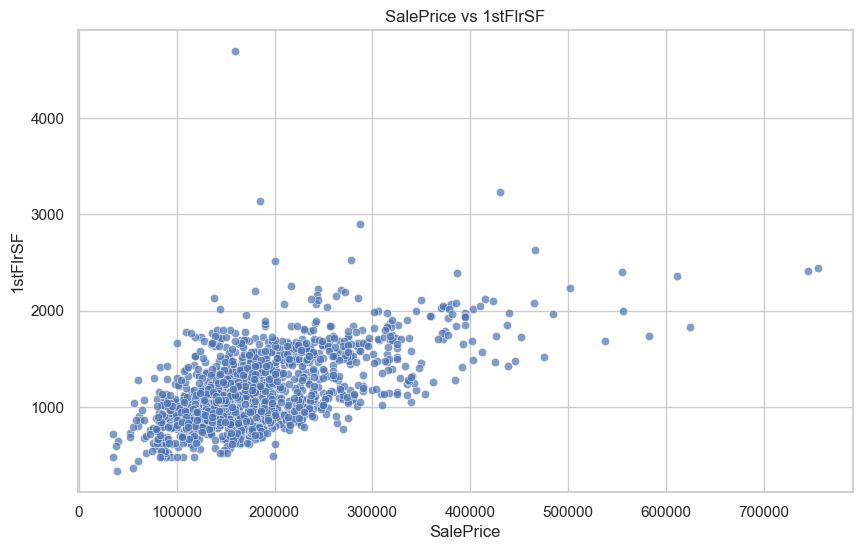

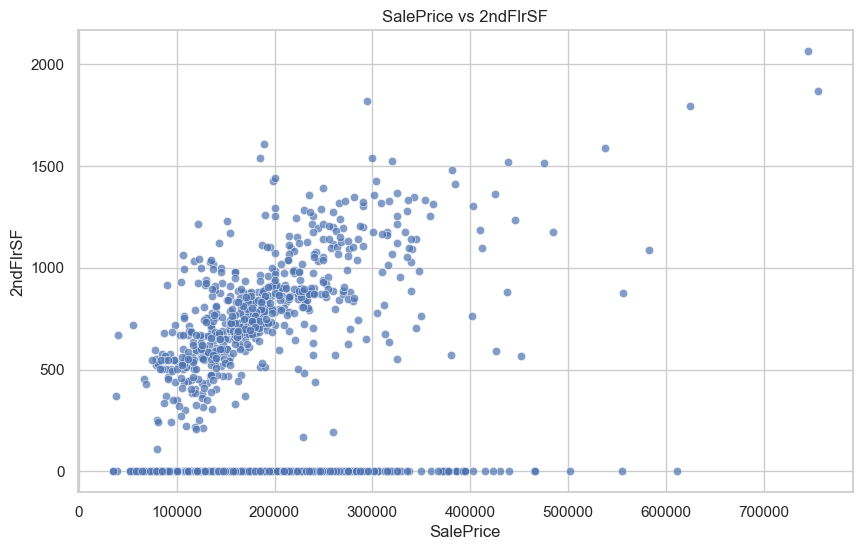

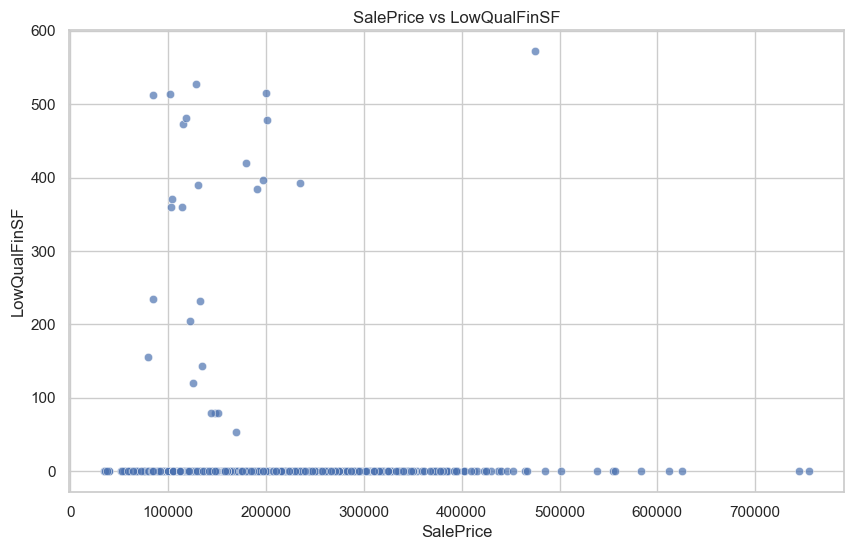

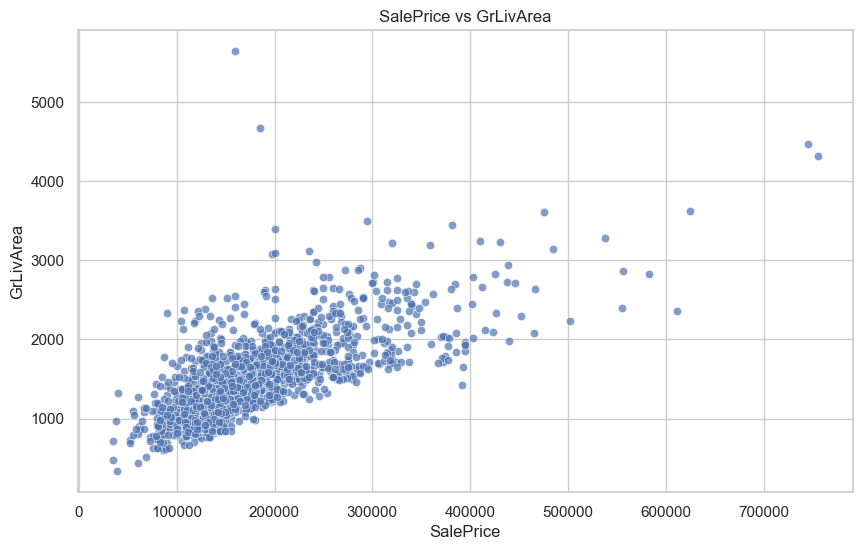

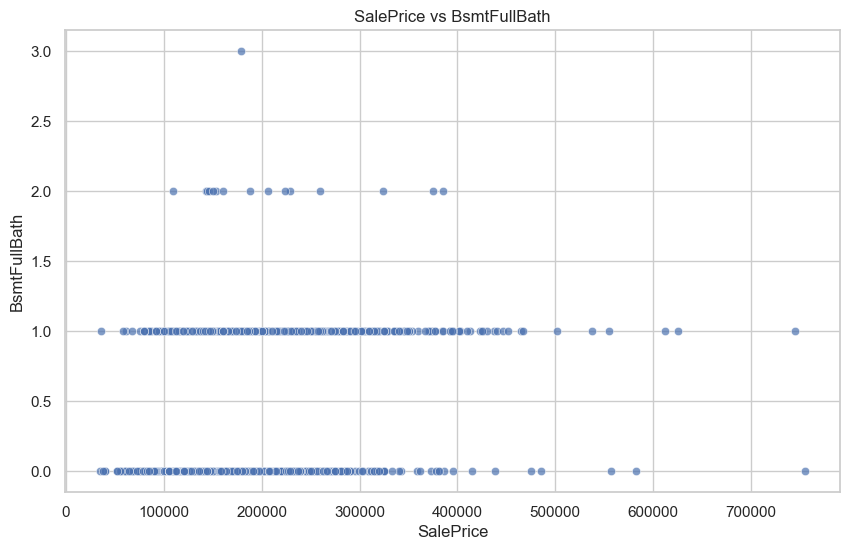

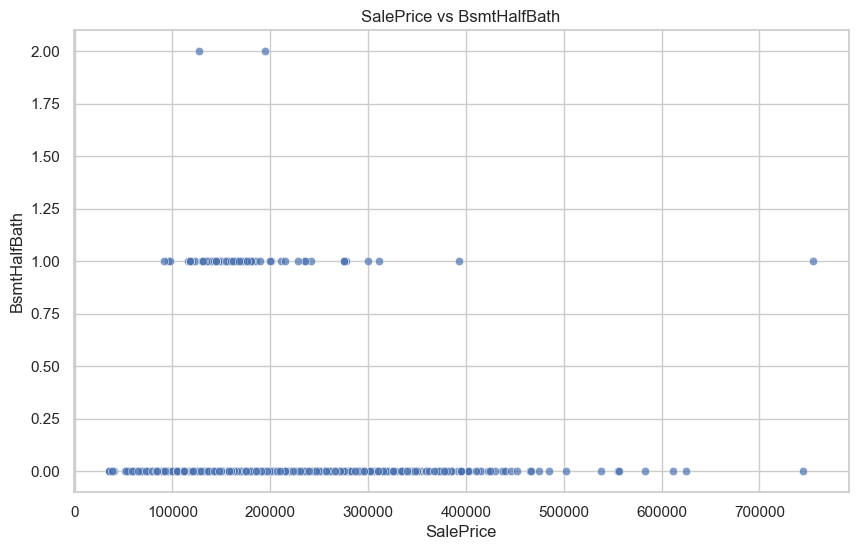

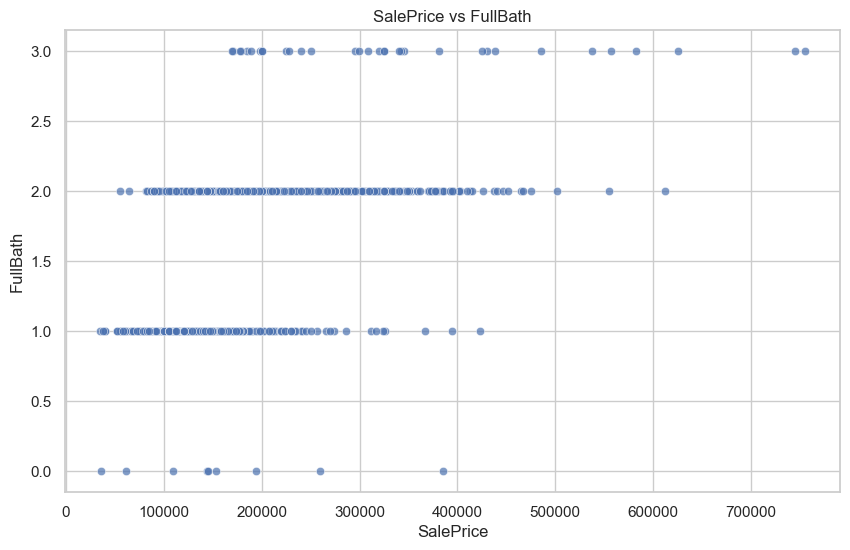

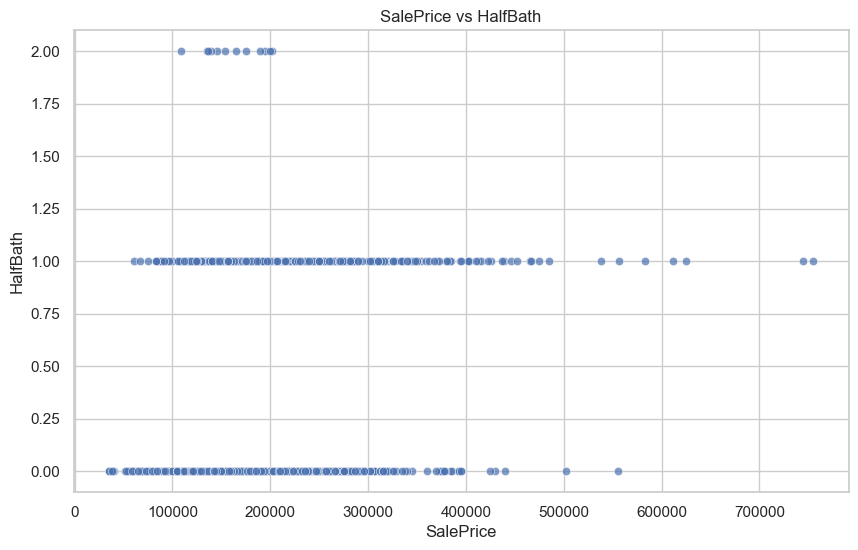

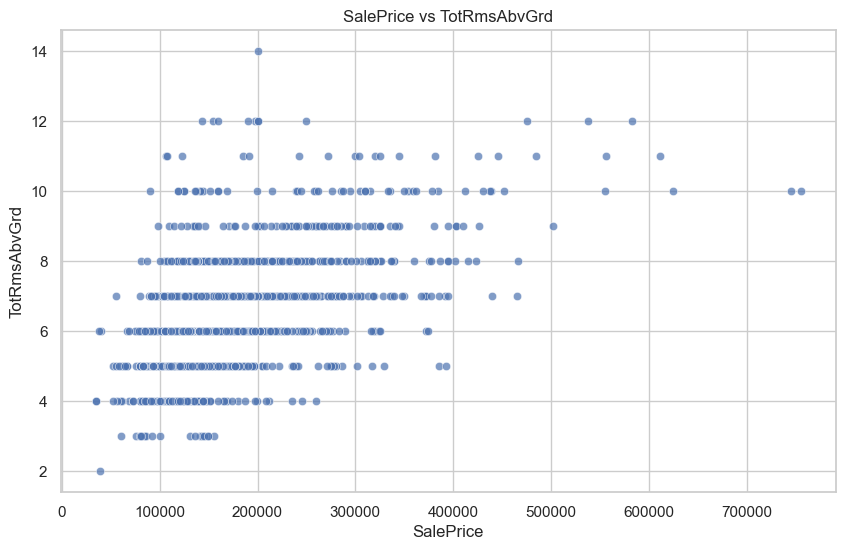

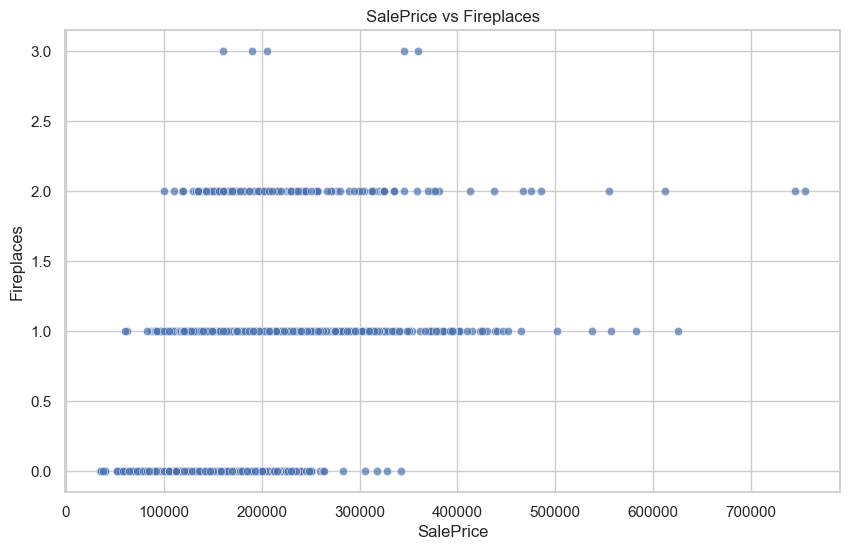

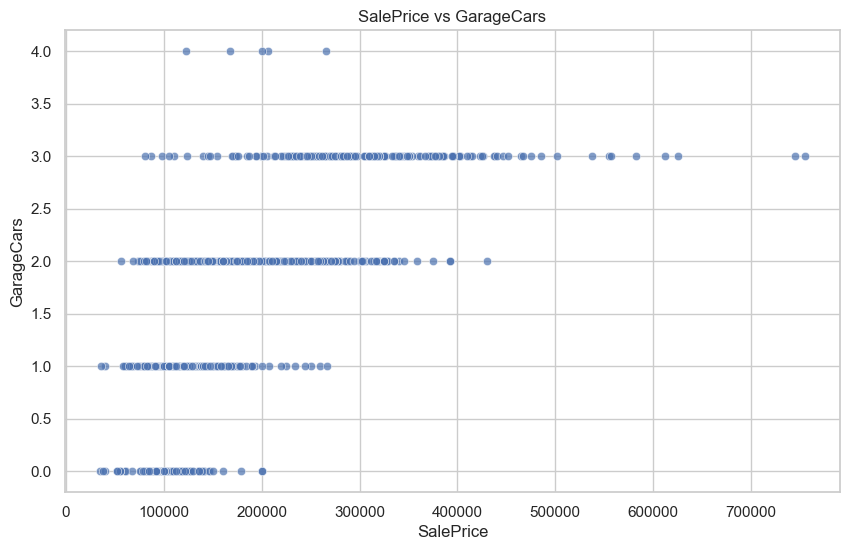

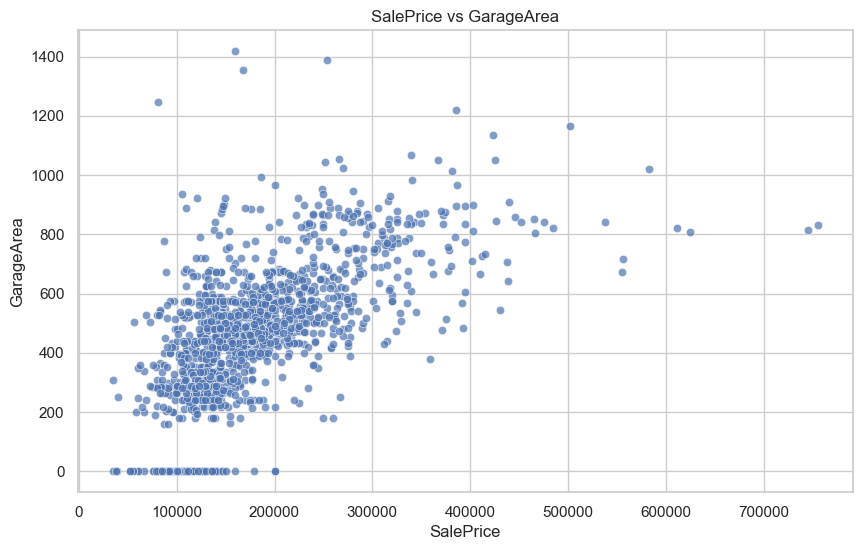

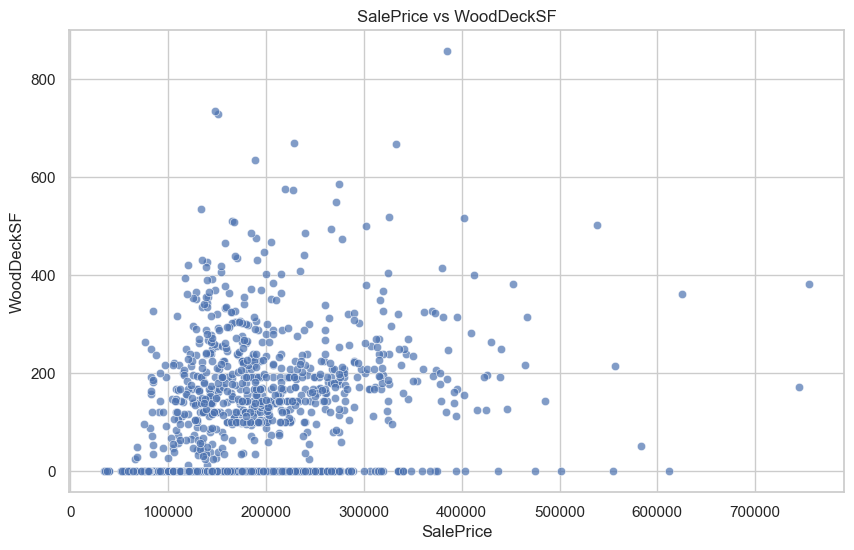

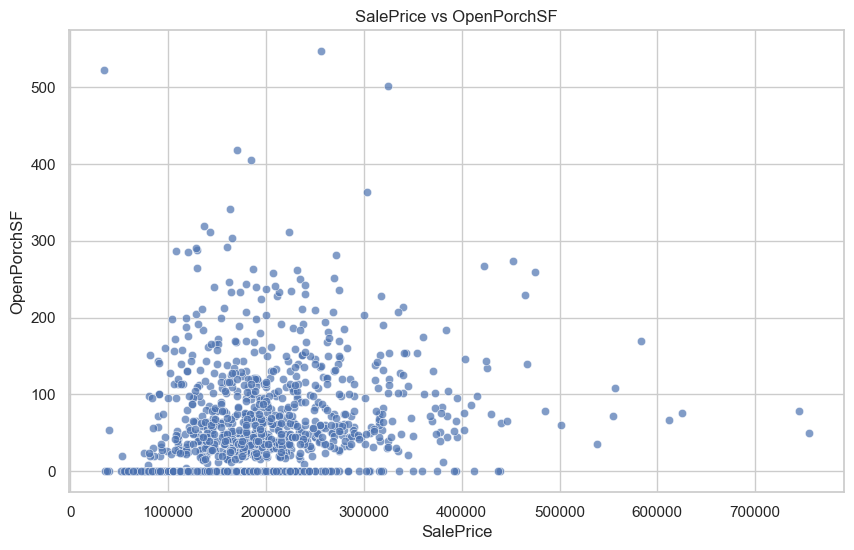

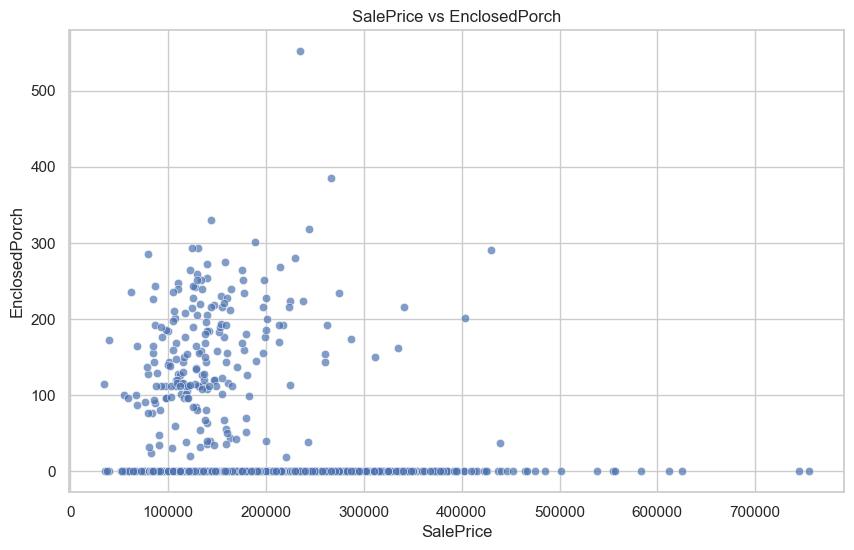

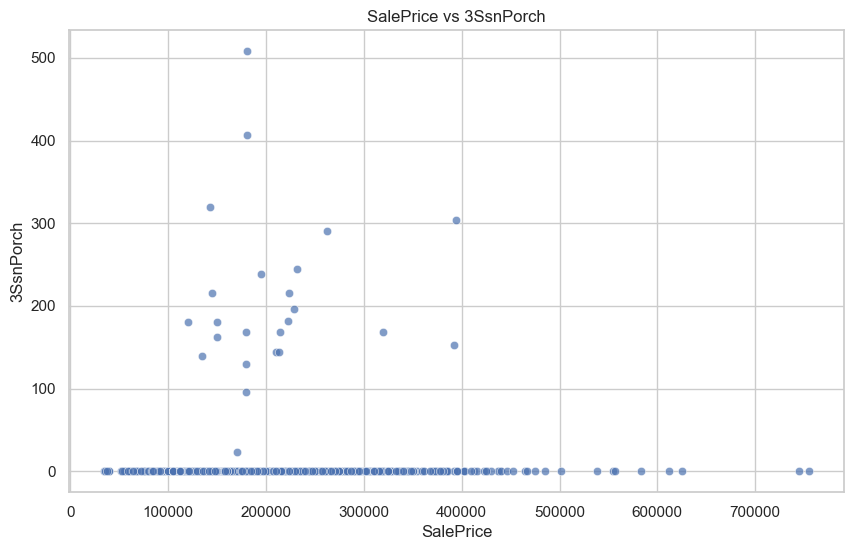

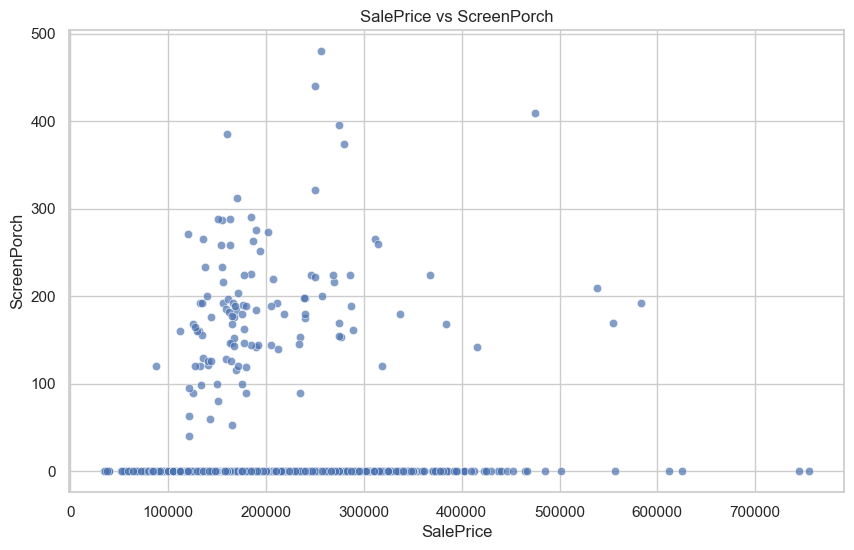

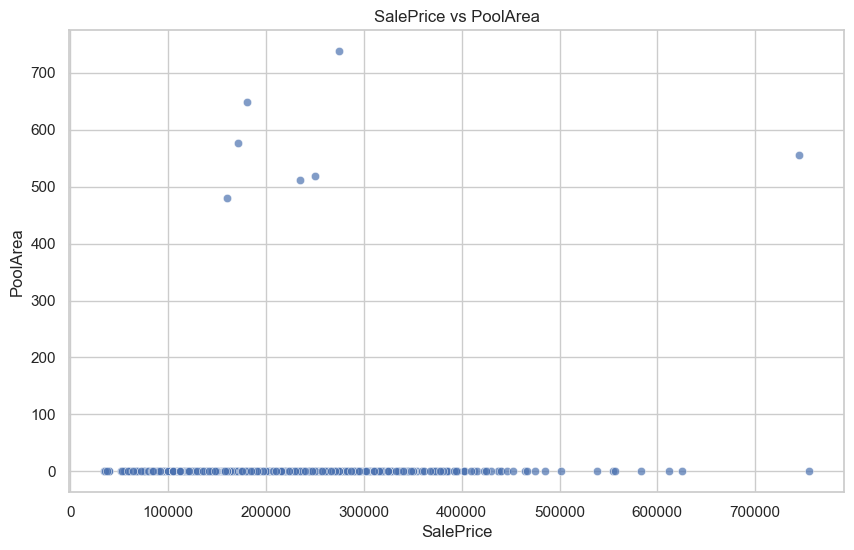

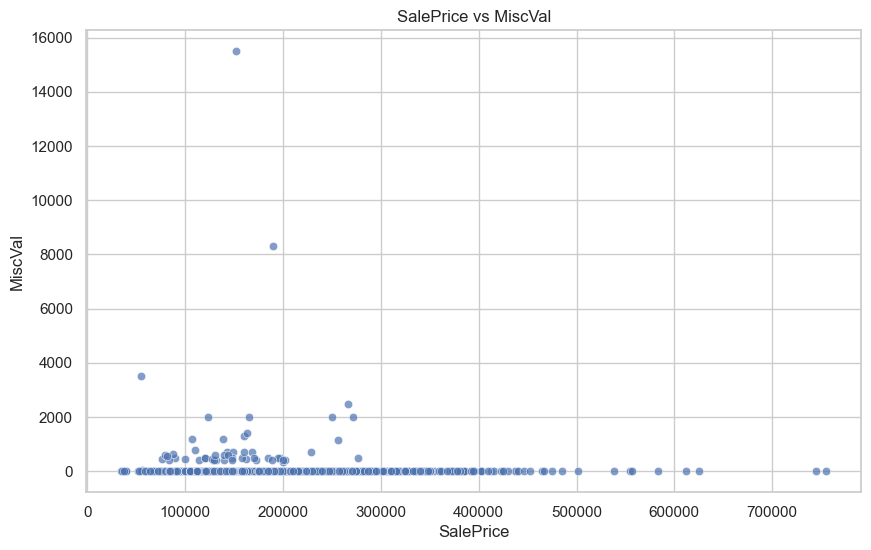

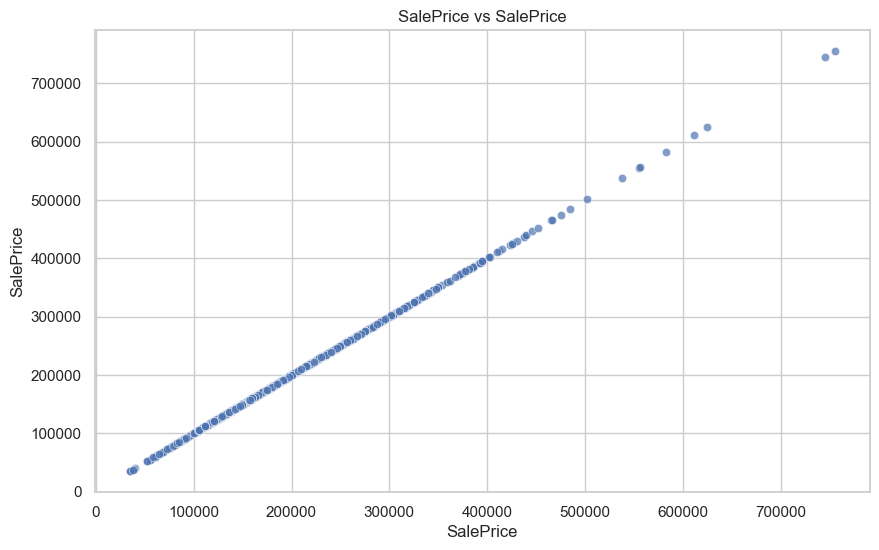

In [393]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Set the style of seaborn
sns.set(style="whitegrid")

numerical_columns_without_SalePrice = ['BedroomAbvGr', 'KitchenAbvGr','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']

# Set the style of seaborn
sns.set(style="whitegrid")

# Plotting numerical columns against SalePrice
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=aus_house_df, x='SalePrice', y=column, alpha=0.7)
    plt.title(f'SalePrice vs {column}')
    plt.xlabel('SalePrice')
    plt.ylabel(column)
    plt.show()


### Observations

- There is no visible pattern for LowQualFinSF. 
    - We can drop this column from our analysis.
    - Append the column list

In [394]:
# drop LowQualFinSF from our dataset 
aus_house_df = aus_house_df.drop('LowQualFinSF', axis=1)

# update the list of Numerical columns
numerical_columns = ['BedroomAbvGr', 'KitchenAbvGr','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']


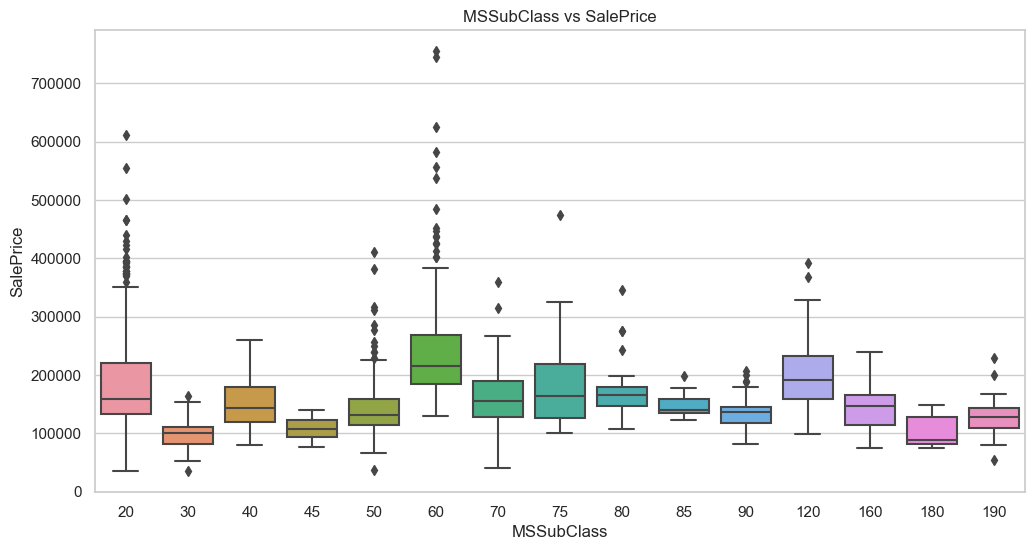

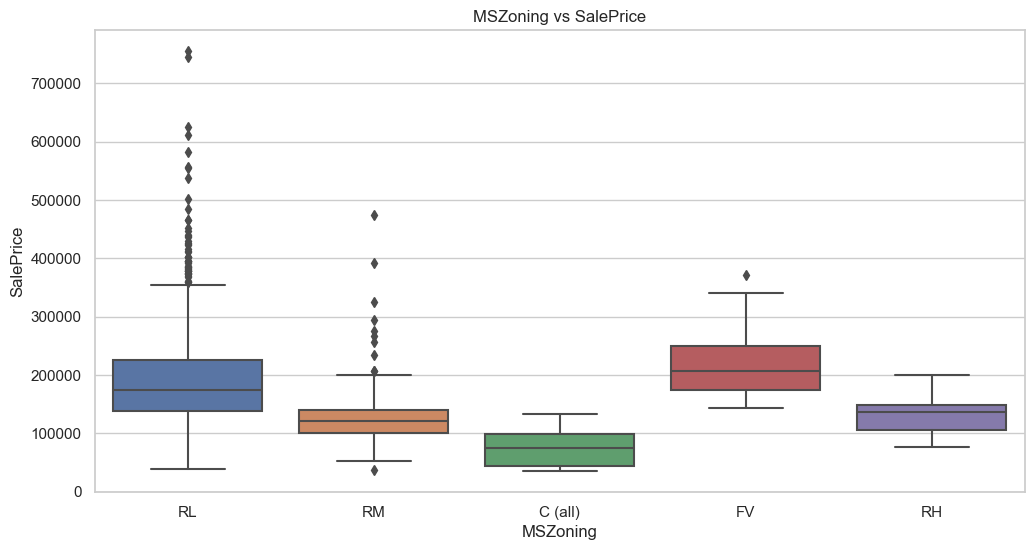

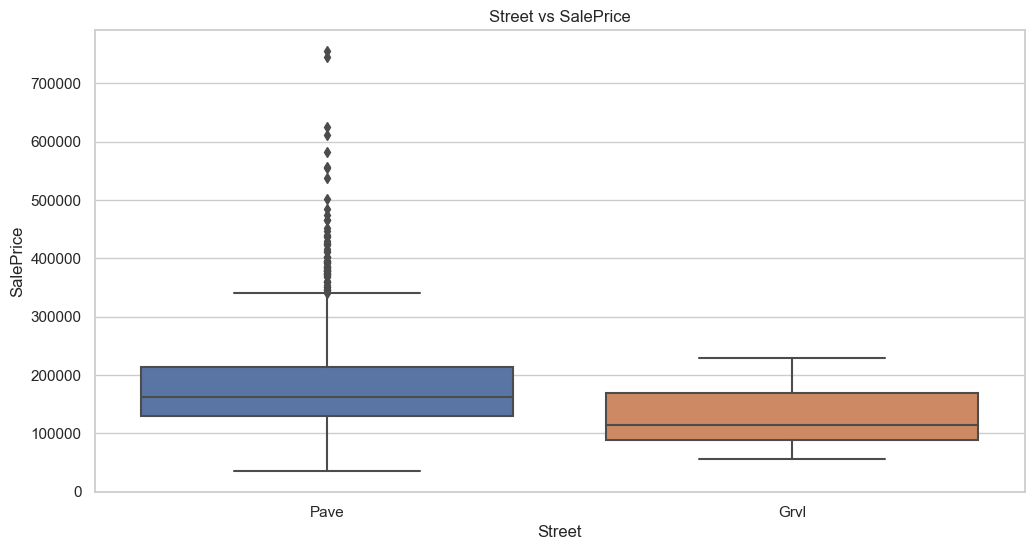

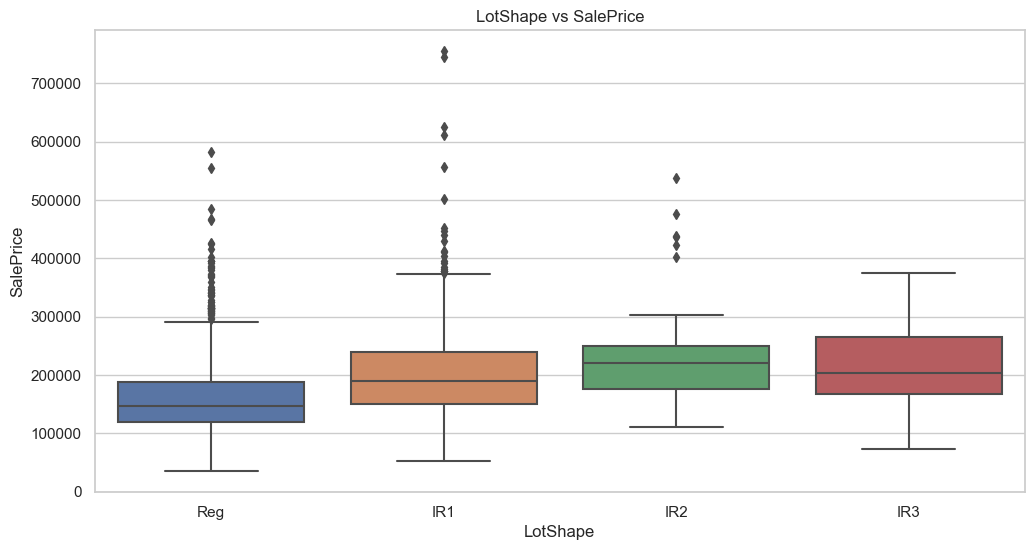

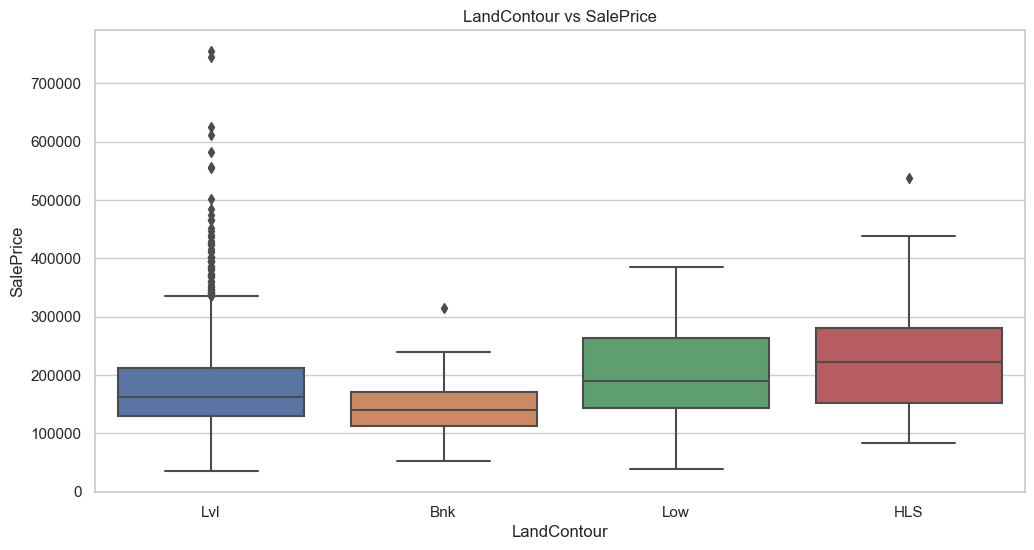

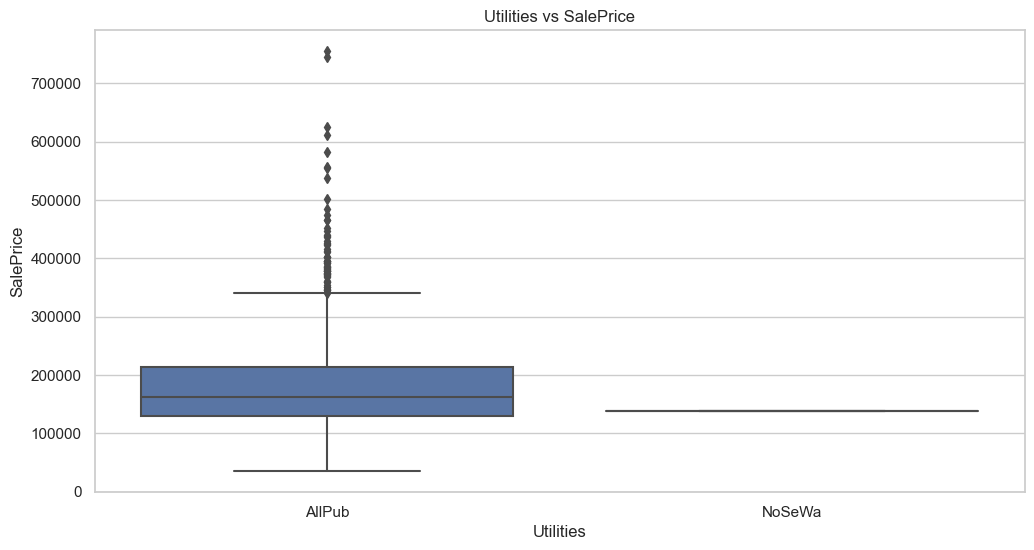

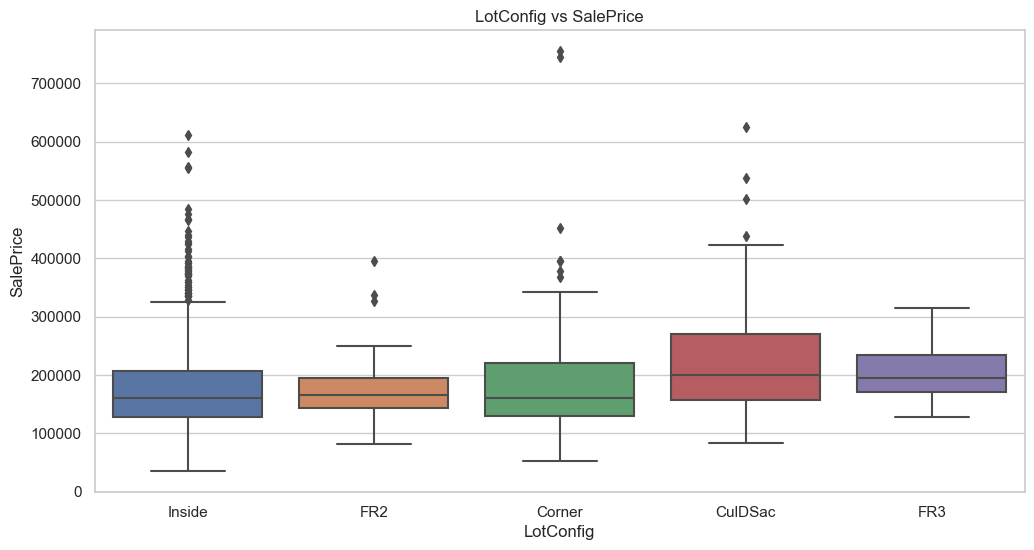

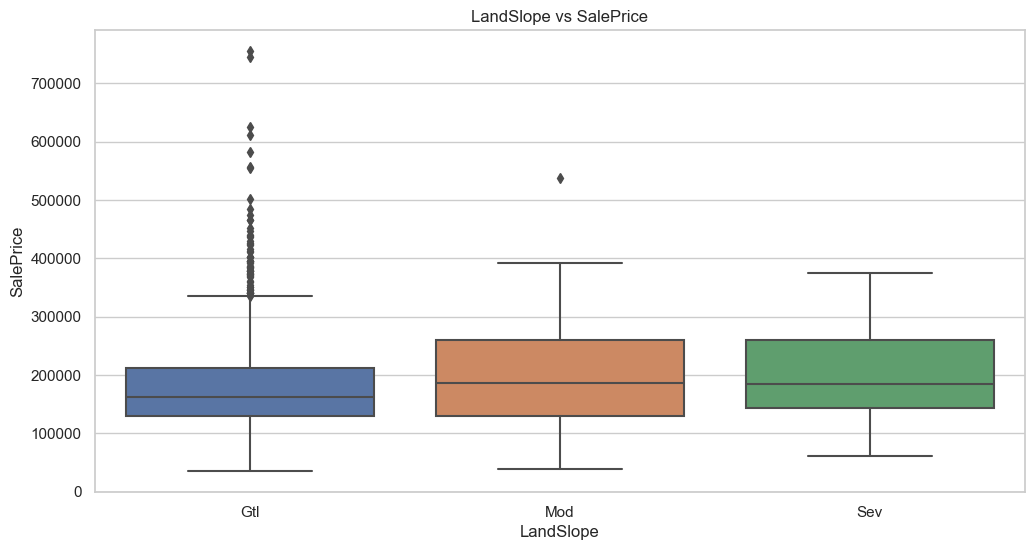

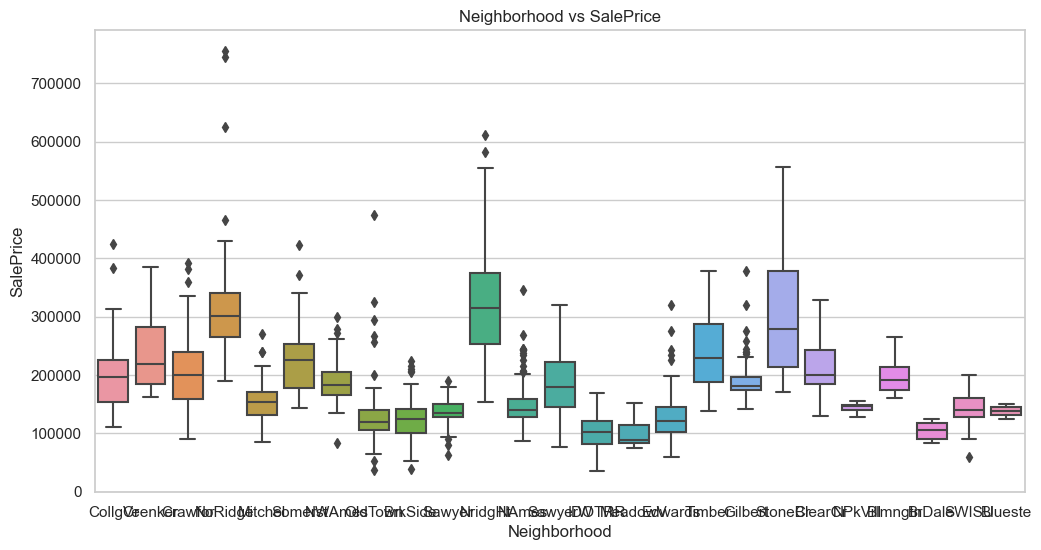

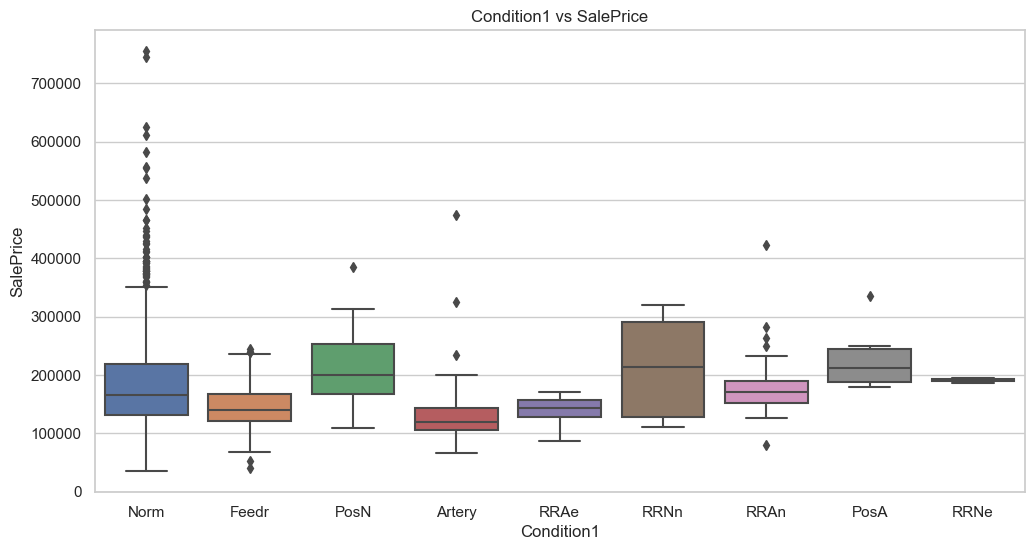

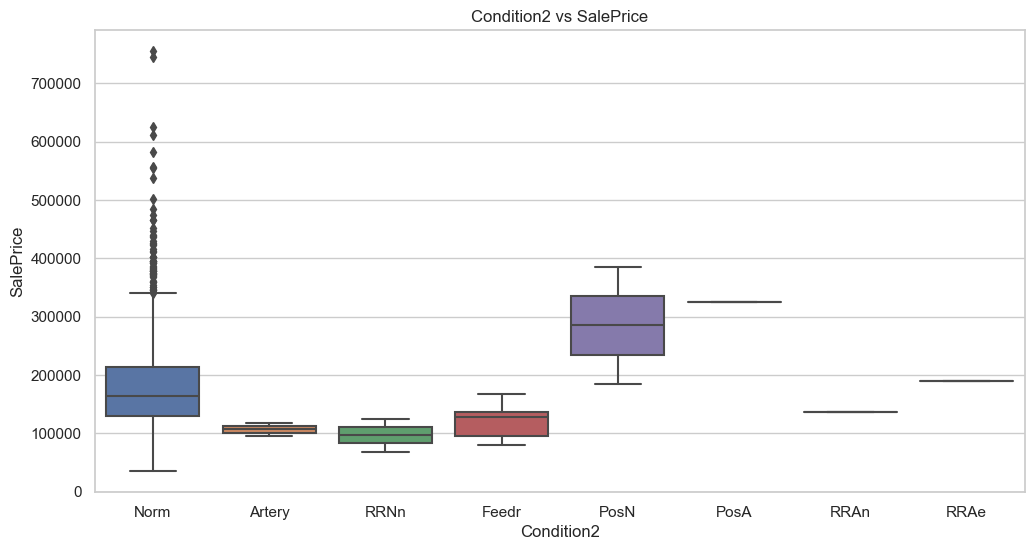

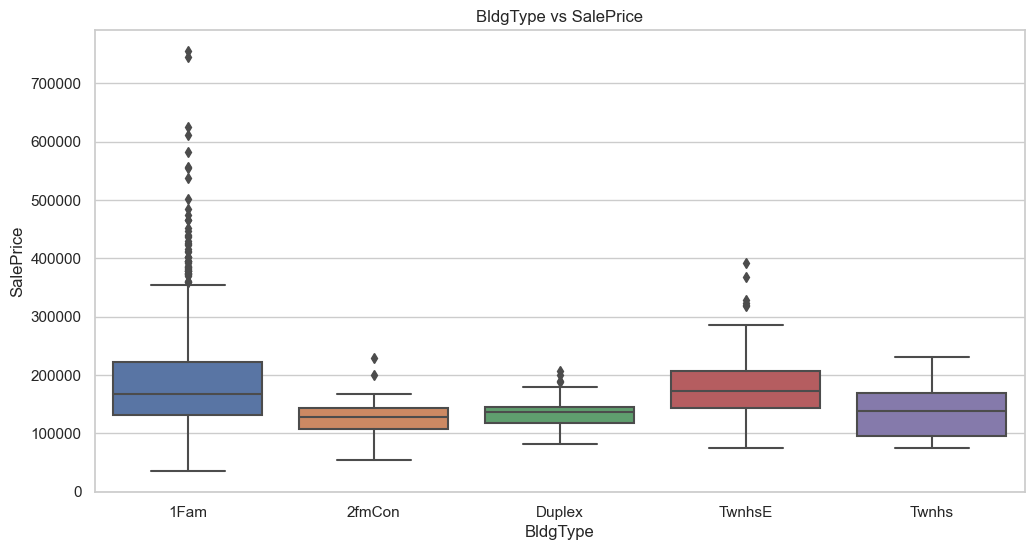

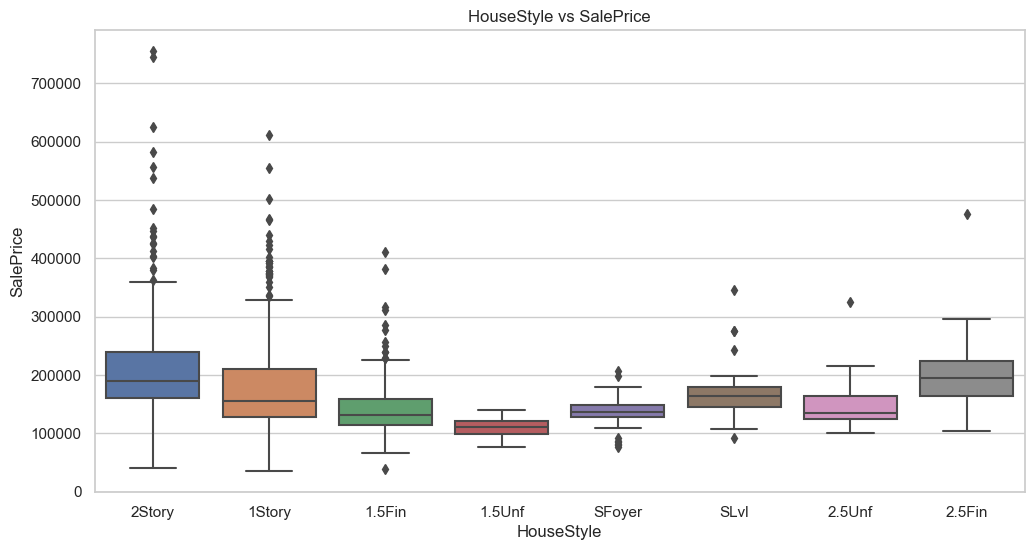

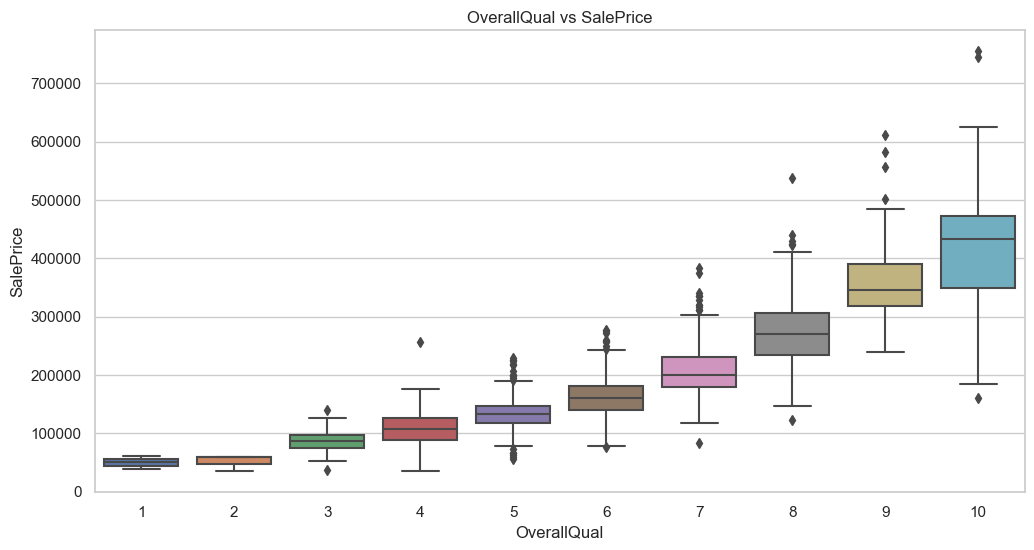

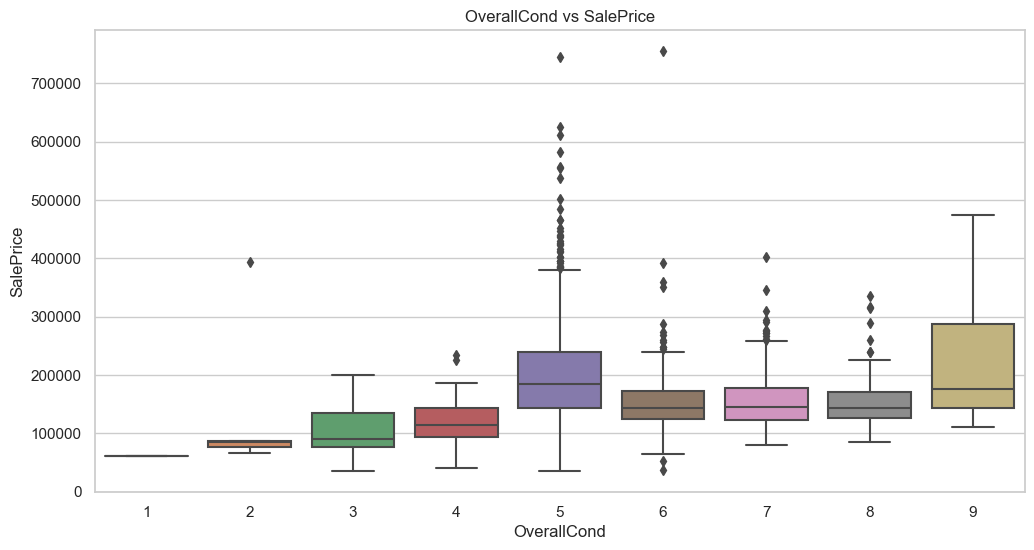

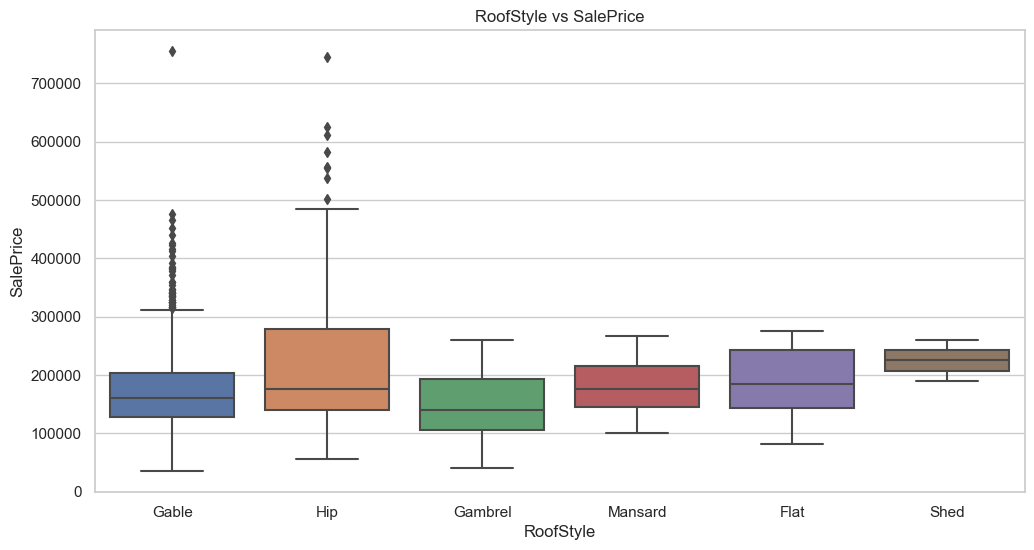

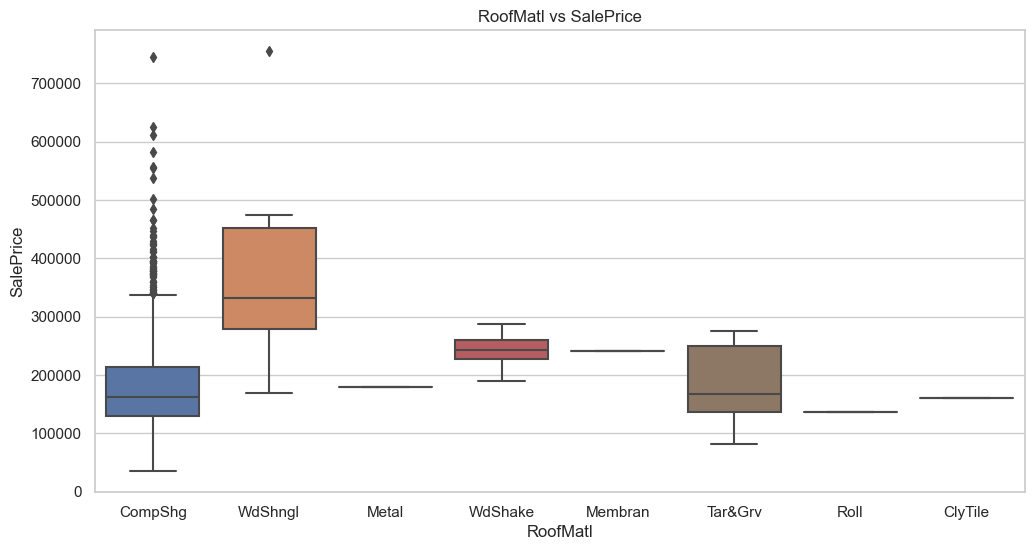

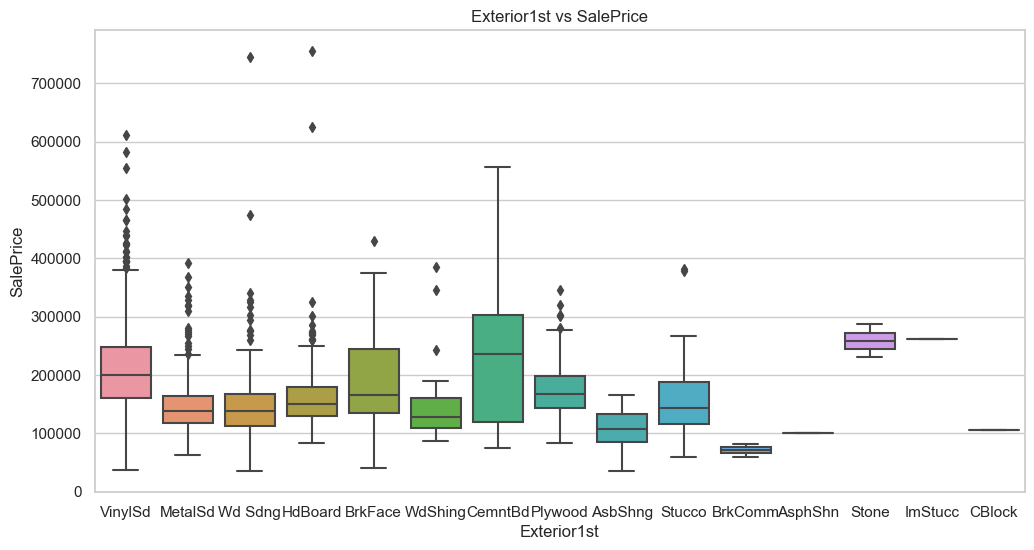

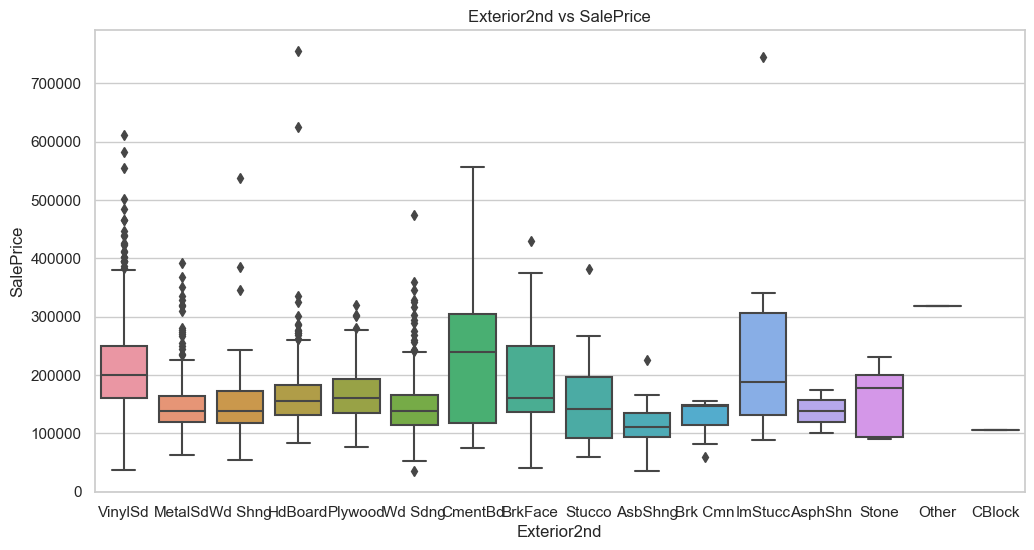

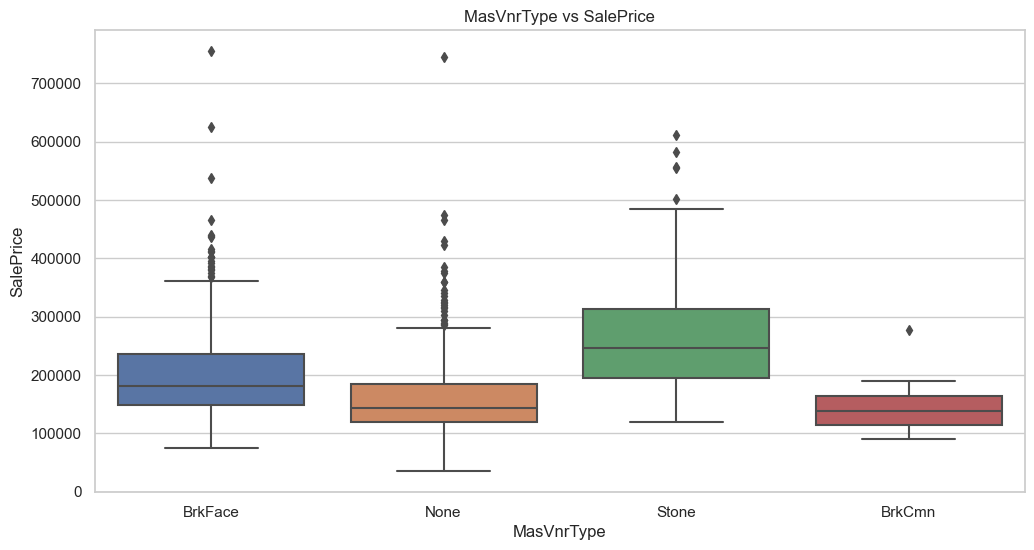

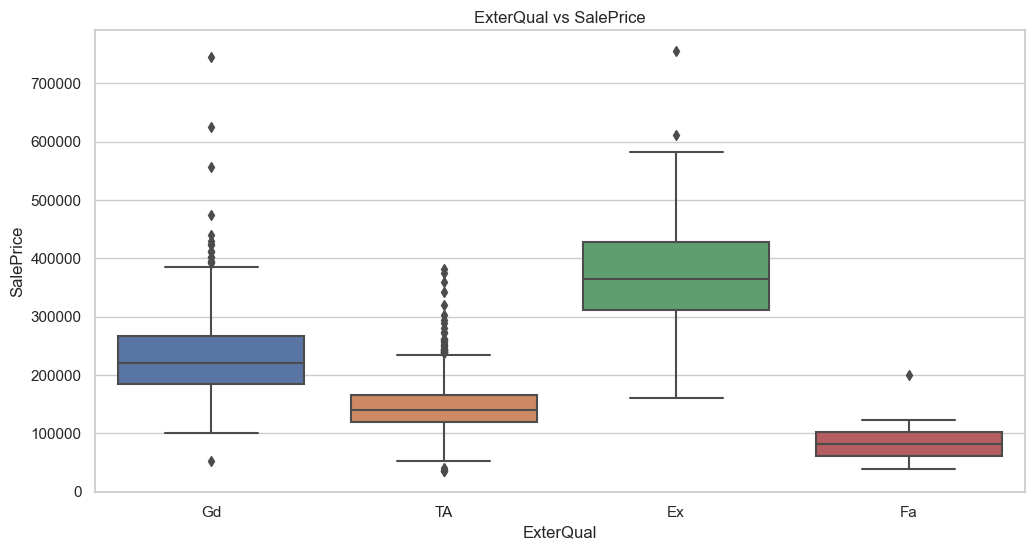

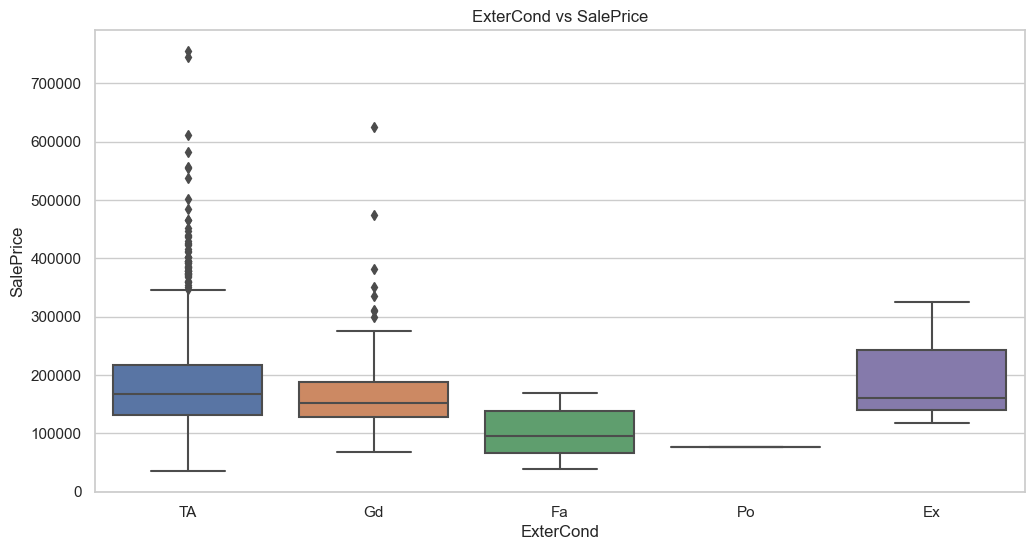

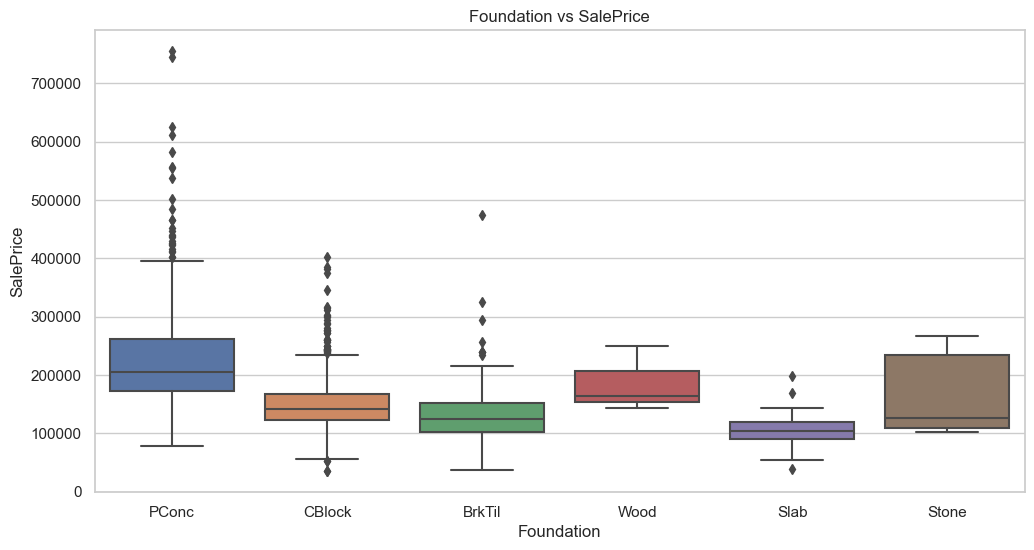

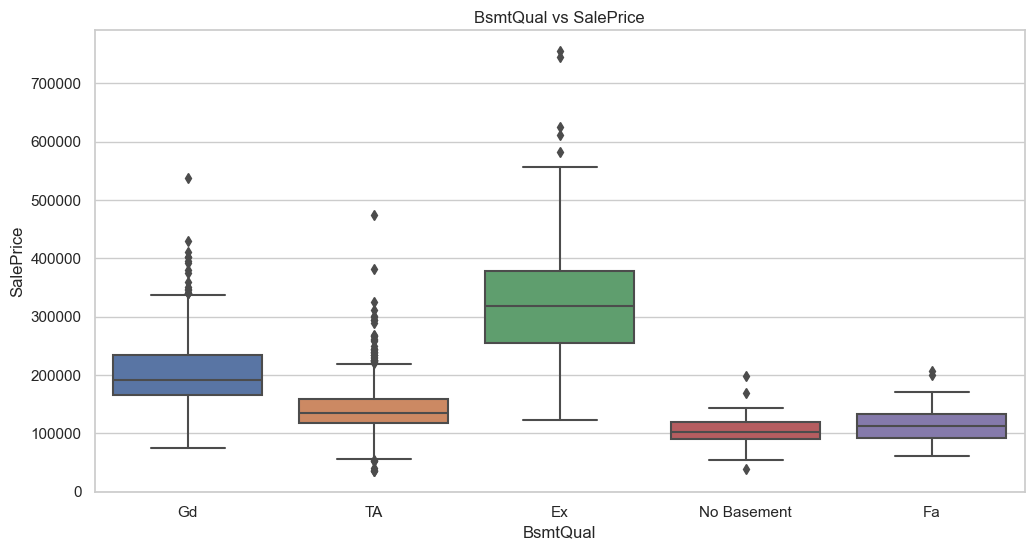

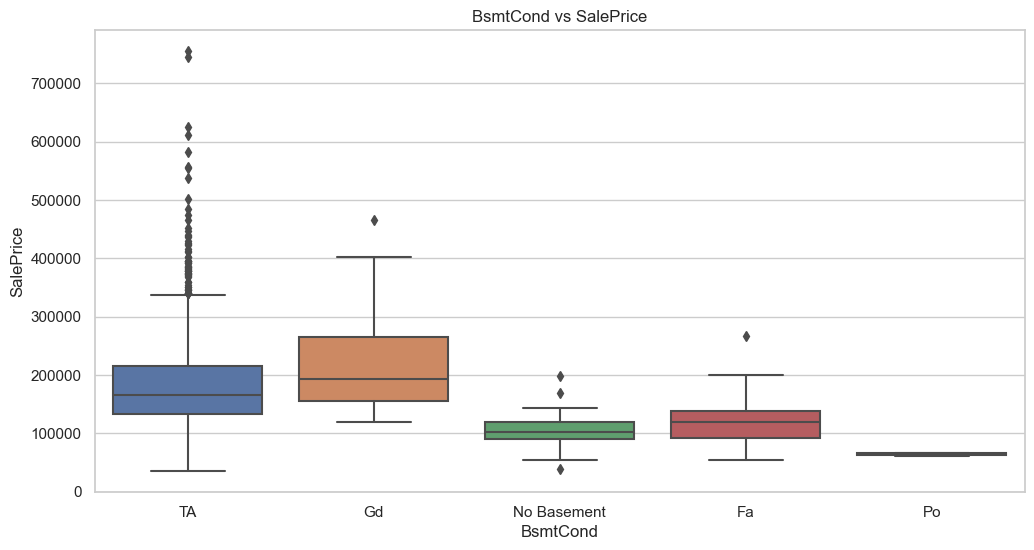

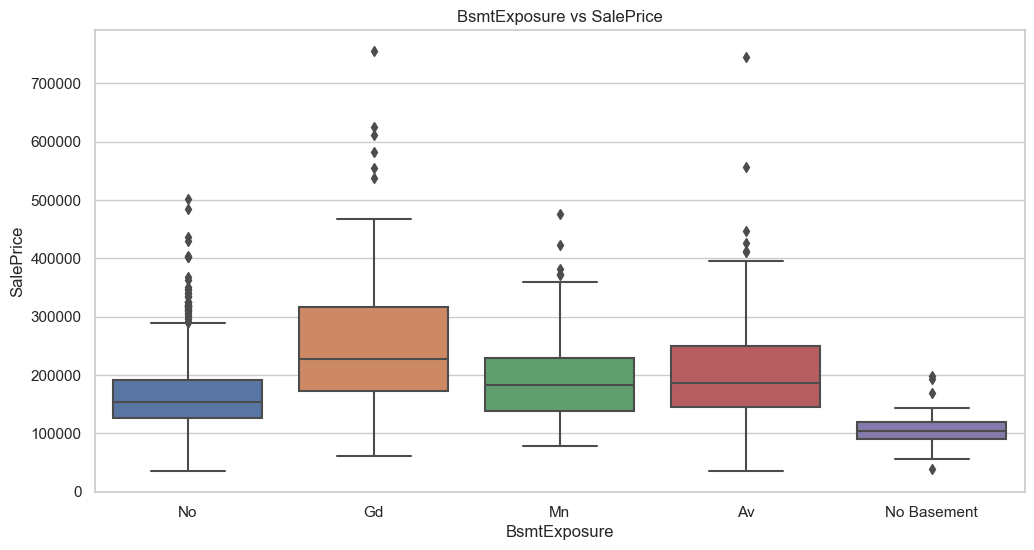

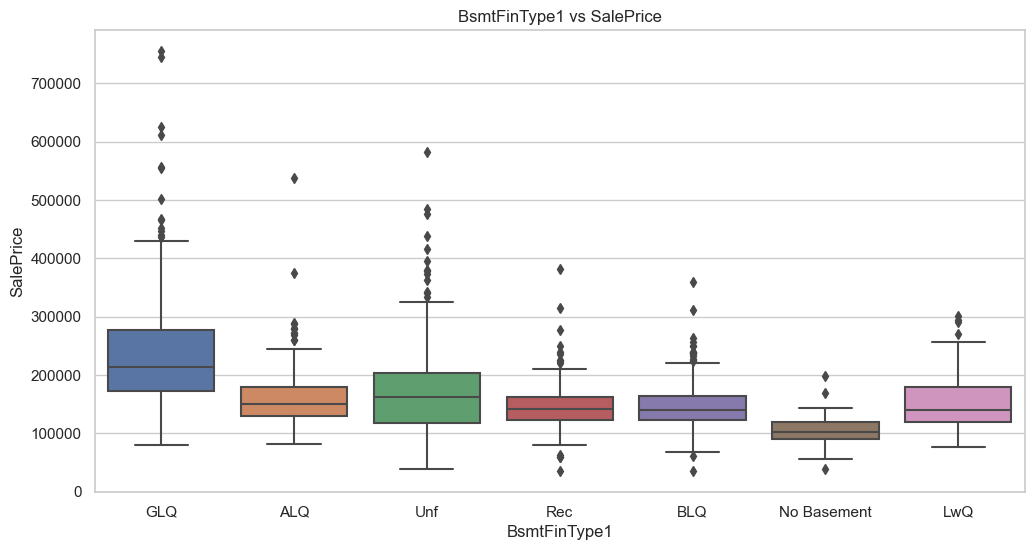

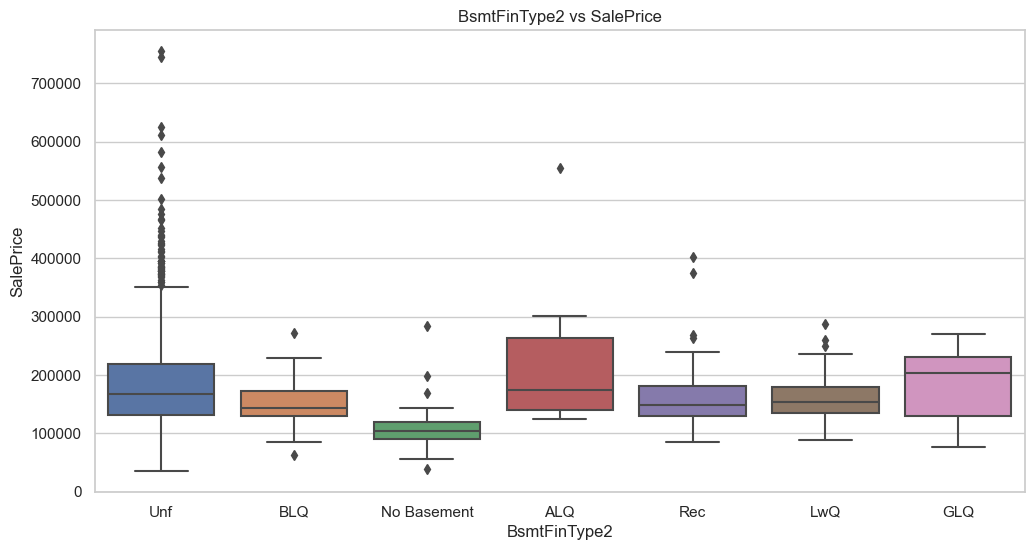

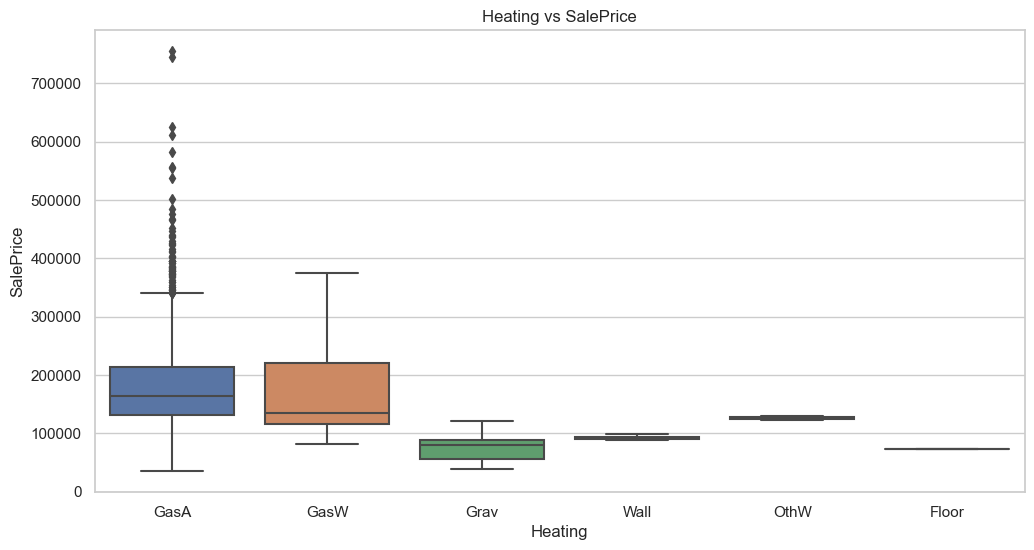

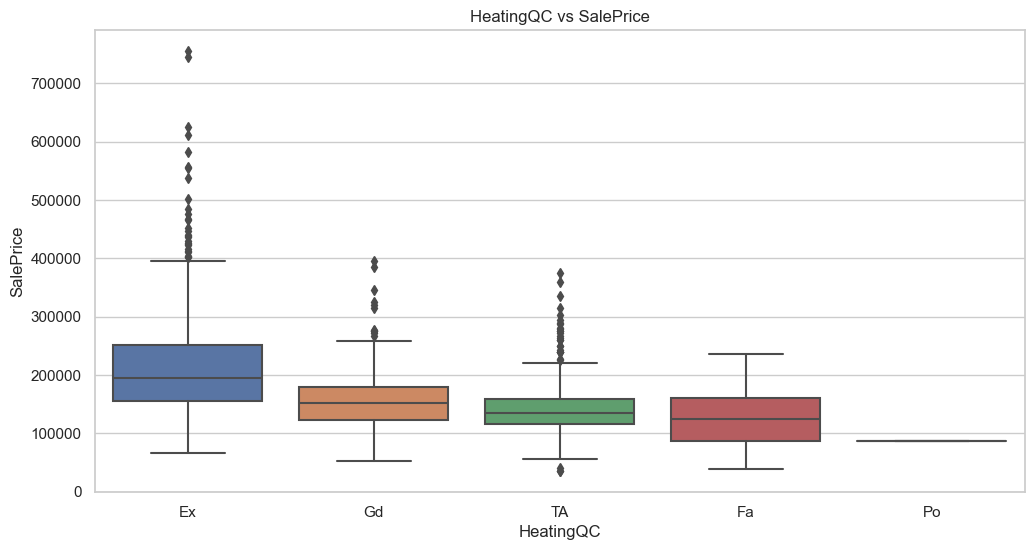

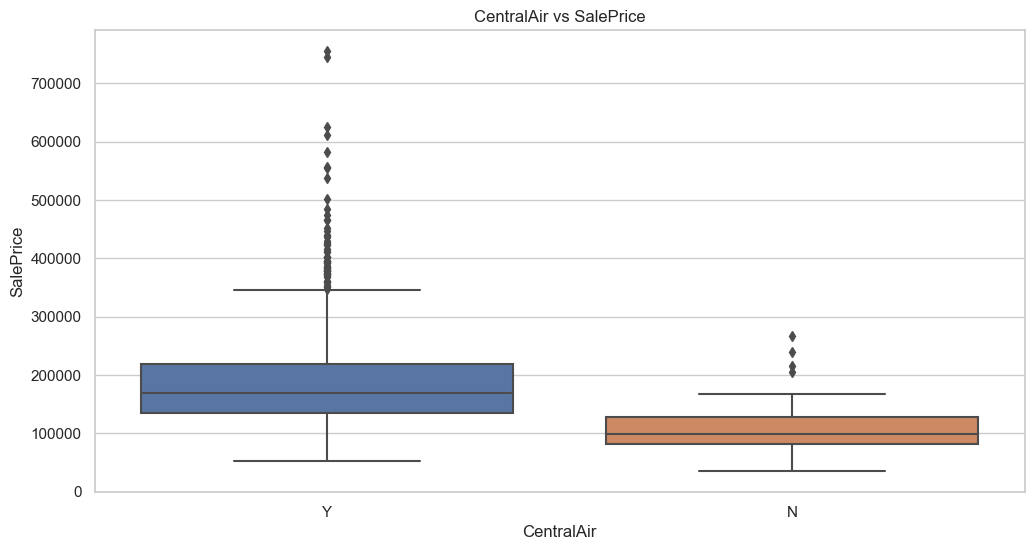

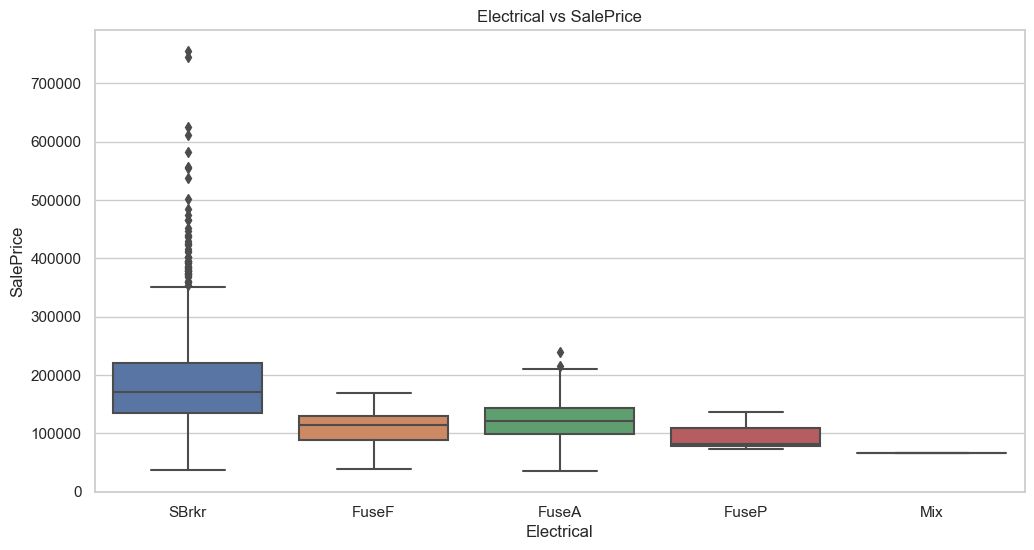

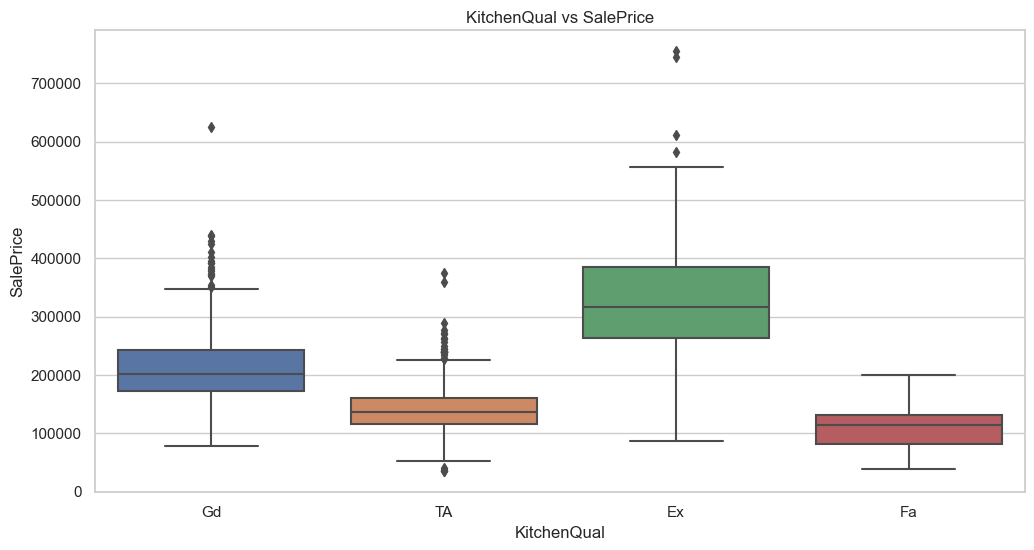

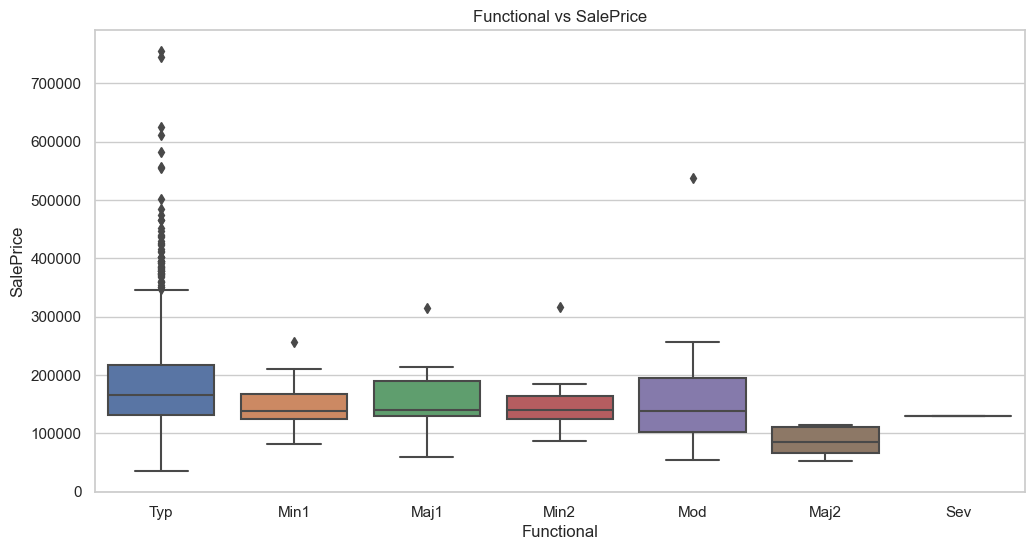

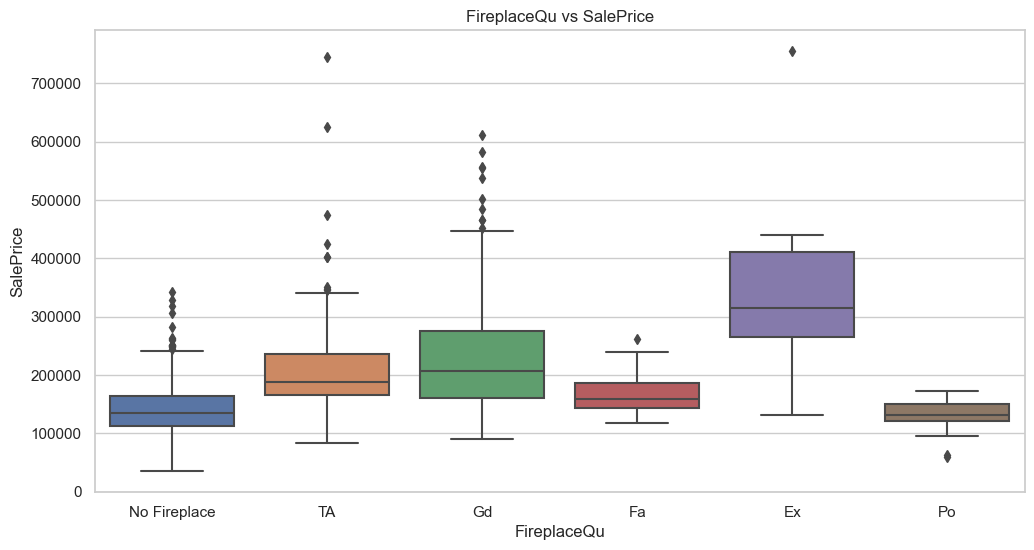

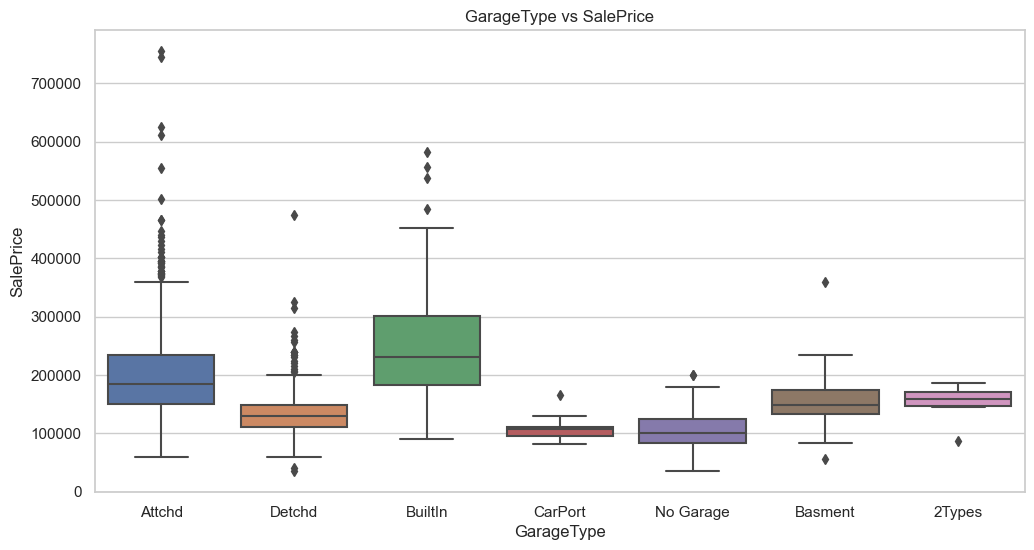

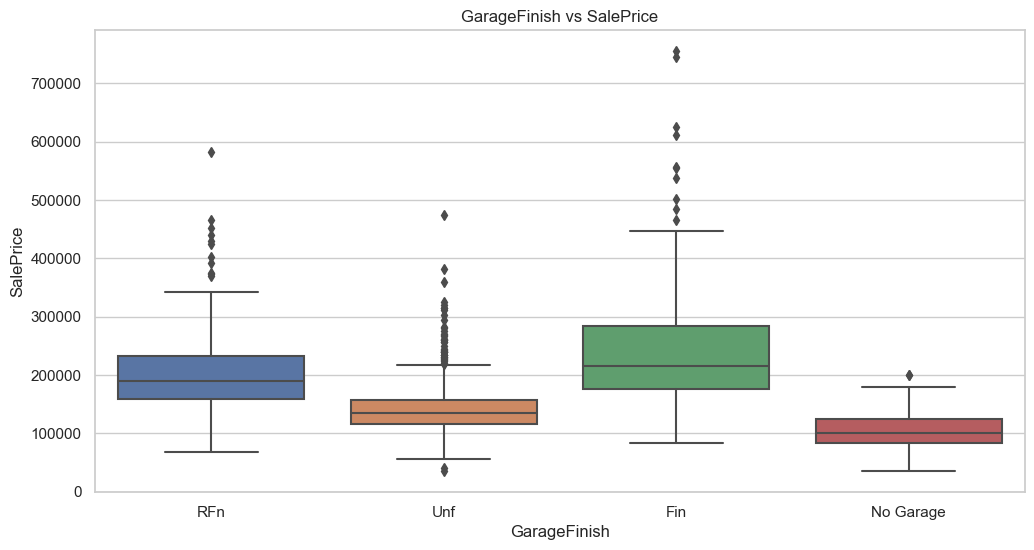

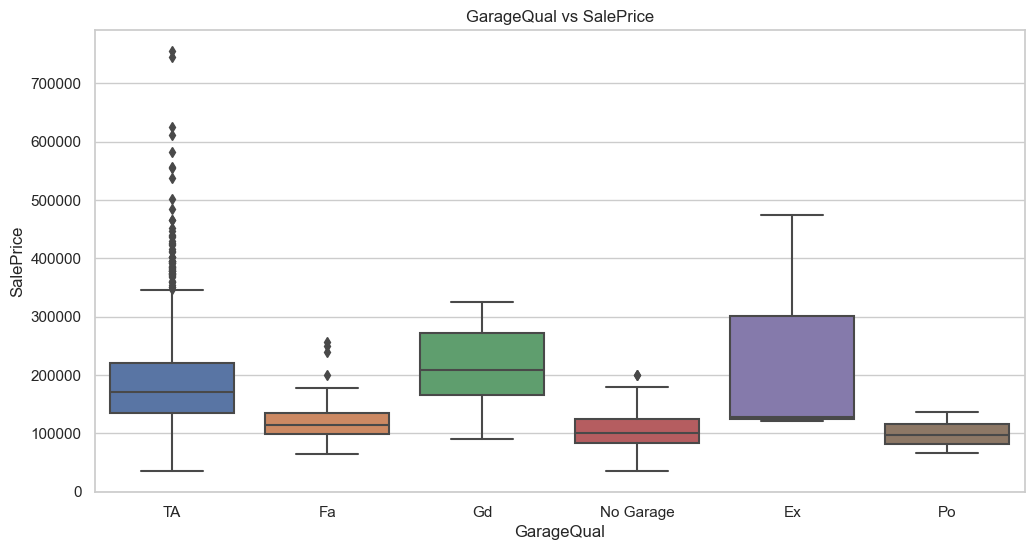

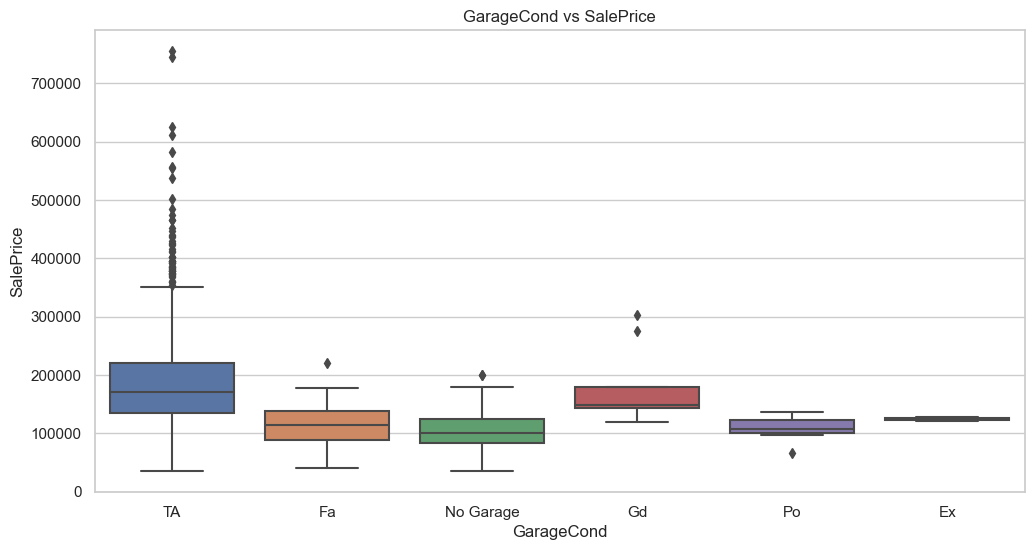

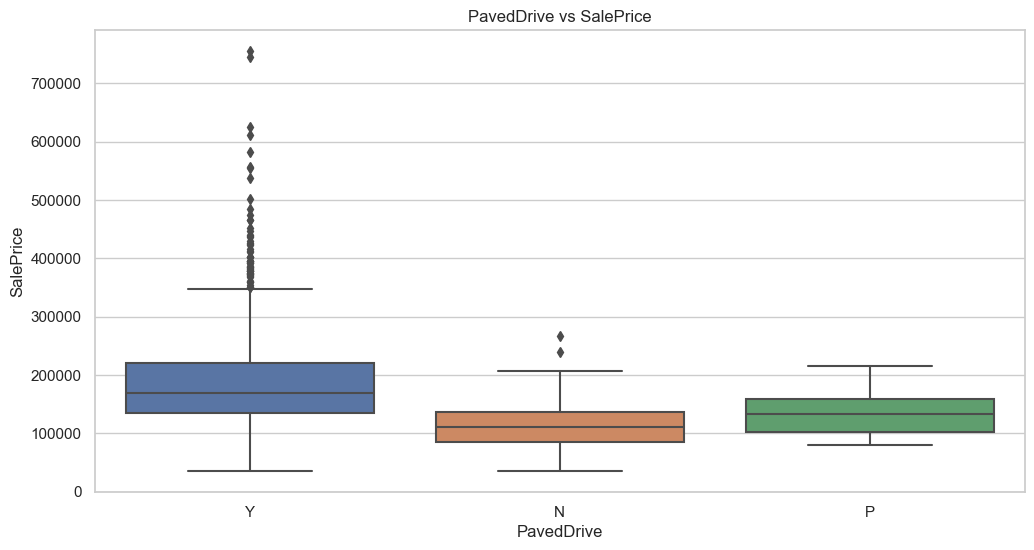

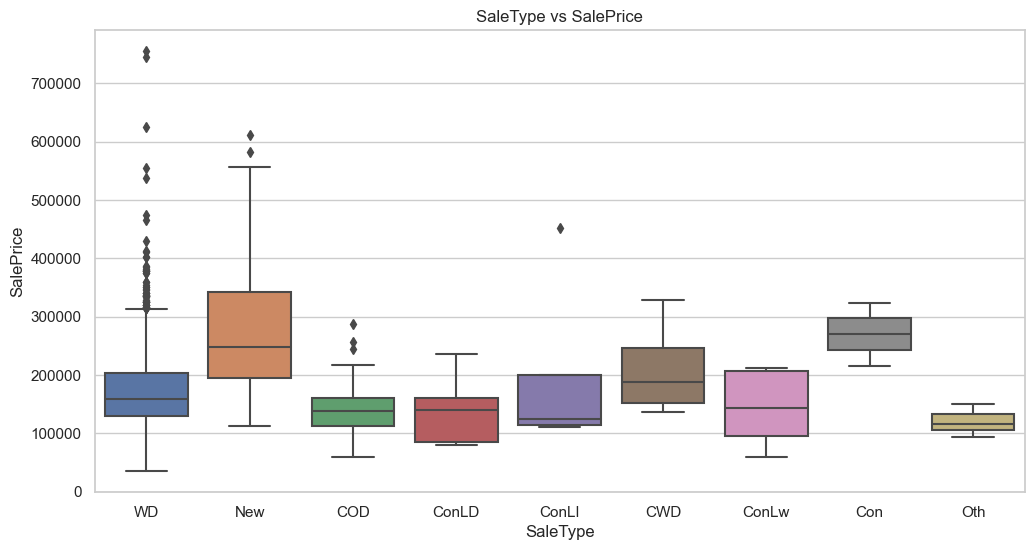

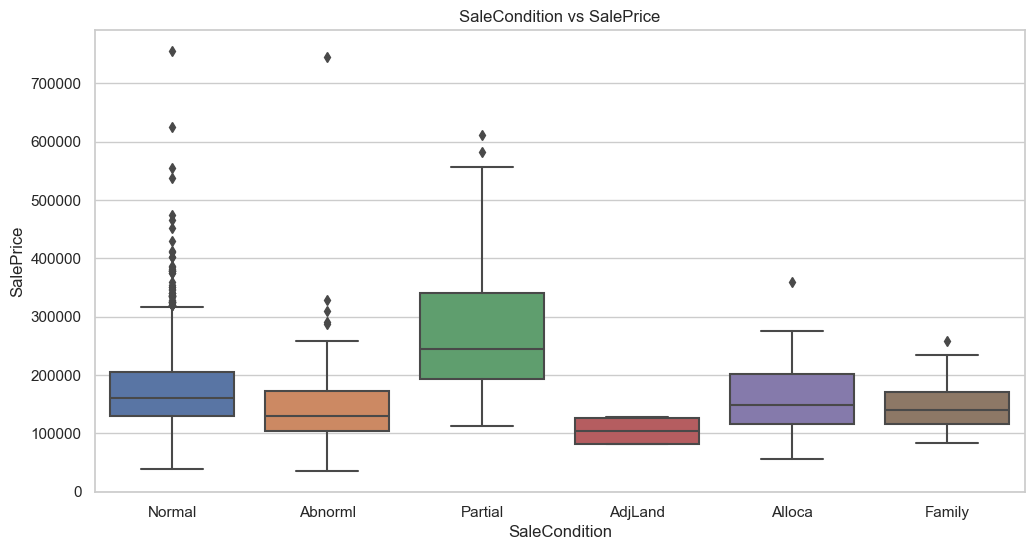

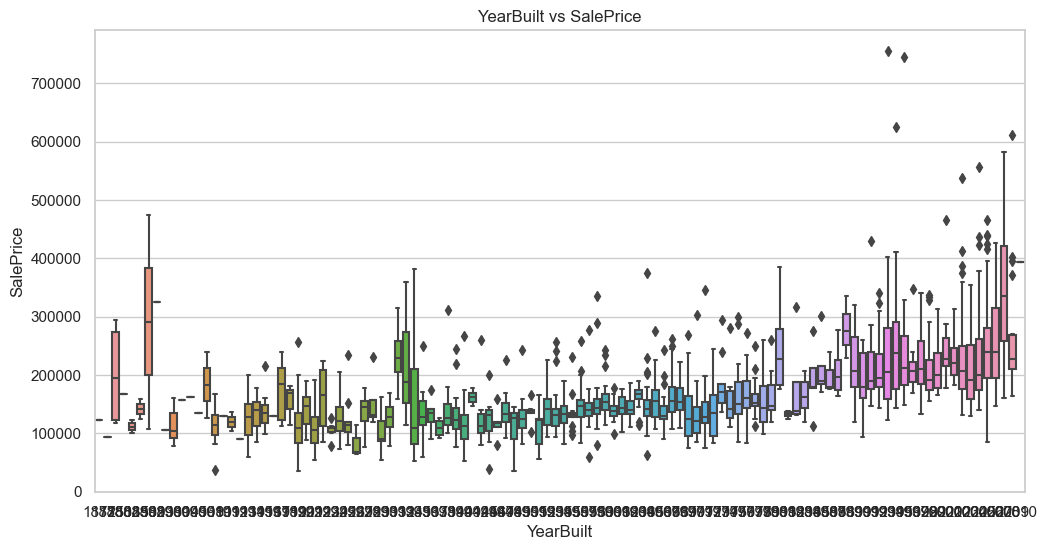

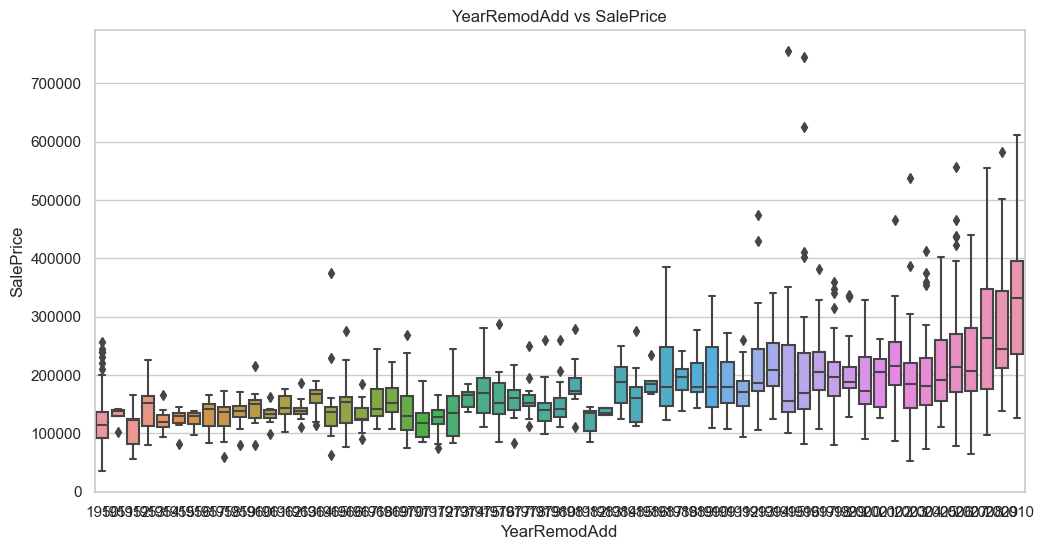

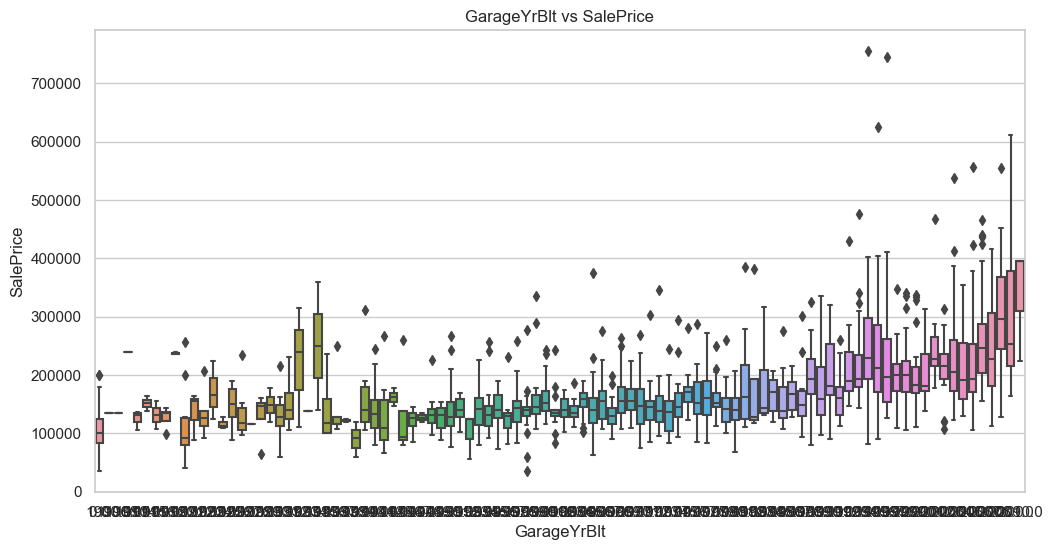

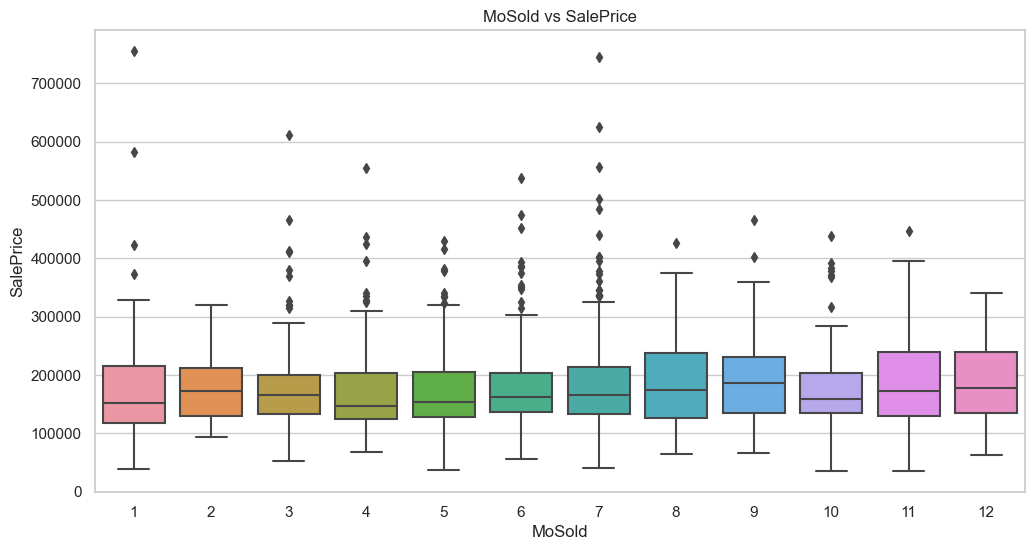

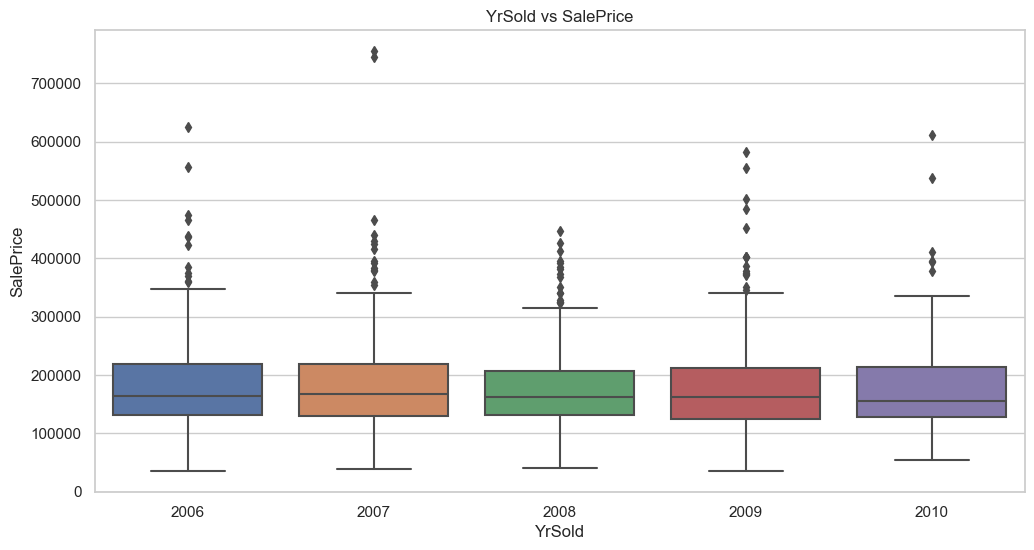

In [395]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in categorical_columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=col, y='SalePrice', data=aus_house_df)
    plt.title(f'{col} vs SalePrice')
    plt.show()


### Observation/s

- 'YrSold' have similar median values and seems doesn't have much impact on the SalePrice
- We can drop YrSold from our analysis
- Update the list of categorical variables


In [396]:
# drop YrSold from our dataset 
aus_house_df = aus_house_df.drop('YrSold', axis=1)

# update the list of Categorical columns
categorical_columns.remove('YrSold')

# Premodel Building : Remove Multicollinearity

We can always check for multicollinearity after encoding but if we can get rid before endcoding it can save computational resources

- Multicollinearity check for variables before encoding
    - Check for correlation by correlation matrix and plot
    - Check for multicollinearity
    - Remove multi collinearity using VIF/RFE etc.
- Encoding: Convert categorical variables in to dummy Variables
    - Multicollinearity check for variables after encoding
    - We will follow Lasso Regularization to take care of the multicollinearity 

In [397]:
# all numeric (float and int) variables in the dataset
aus_house_df_numeric = aus_house_df.select_dtypes(include=['float64', 'int64'])
aus_house_df_numeric.head()

LotFrontage  LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
0         65.0   8450.0       196.0       706.0         0.0      150.0   
1         80.0   9600.0         0.0       978.0         0.0      284.0   
2         68.0  11250.0       162.0       486.0         0.0      434.0   
3         60.0   9550.0         0.0       216.0         0.0      540.0   
4         84.0  14260.0       350.0       655.0         0.0      490.0   

   TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  ...  GarageCars  GarageArea  \
0        856.0     856.0     854.0     1710.0  ...         2.0       548.0   
1       1262.0    1262.0       0.0     1262.0  ...         2.0       460.0   
2        920.0     920.0     866.0     1786.0  ...         2.0       608.0   
3        756.0     961.0     756.0     1717.0  ...         3.0       642.0   
4       1145.0    1145.0    1053.0     2198.0  ...         3.0       836.0   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0         0.0         61.0            0.0        0.0          0.0       0.0   
1       298.0          0.0            0.0        0.0          0.0       0.0   
2         0.0         42.0            0.0        0.0          0.0       0.0   
3         0.0         35.0          272.0        0.0          0.0       0.0   
4       192.0         84.0            0.0        0.0          0.0       0.0   

   MiscVal  SalePrice  
0      0.0   208500.0  
1      0.0   181500.0  
2      0.0   223500.0  
3      0.0   140000.0  
4      0.0   250000.0  

[5 rows x 29 columns]

In [398]:
# correlation matrix
cor = aus_house_df_numeric.corr()
cor

LotFrontage   LotArea  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
LotFrontage       1.000000  0.100770    0.105202    0.076996   -0.009225   
LotArea           0.100770  1.000000    0.103302    0.214121    0.111158   
MasVnrArea        0.105202  0.103302    1.000000    0.260989   -0.071453   
BsmtFinSF1        0.076996  0.214121    0.260989    1.000000   -0.050328   
BsmtFinSF2       -0.009225  0.111158   -0.071453   -0.050328    1.000000   
BsmtUnfSF         0.160976 -0.002641    0.113719   -0.495718   -0.209395   
TotalBsmtSF       0.238950  0.260962    0.359798    0.521963    0.104593   
1stFlrSF          0.245613  0.299533    0.339605    0.445473    0.096948   
2ndFlrSF          0.042354  0.051030    0.174109   -0.136697   -0.099146   
GrLivArea         0.220436  0.263109    0.388012    0.208088   -0.009686   
BsmtFullBath      0.010767  0.158147    0.082718    0.649025    0.158557   
BsmtHalfBath     -0.027785  0.048034    0.027312    0.067281    0.070904   
FullBath          0.120342  0.126100    0.273397    0.059102   -0.076306   
HalfBath         -0.013333  0.014333    0.199713    0.005085   -0.031922   
BedroomAbvGr      0.144455  0.119700    0.102851   -0.107281   -0.015696   
KitchenAbvGr      0.034492 -0.017796   -0.038538   -0.081175   -0.040795   
TotRmsAbvGrd      0.221328  0.190037    0.279724    0.044529   -0.035170   
Fireplaces        0.044324  0.271398    0.246747    0.259541    0.046748   
GarageYrBlt       0.019226  0.072618    0.132835    0.116087    0.035132   
GarageCars        0.165150  0.154893    0.362119    0.224342   -0.038204   
GarageArea        0.201599  0.180392    0.370807    0.296851   -0.018295   
WoodDeckSF       -0.016795  0.171701    0.160026    0.204403    0.067909   
OpenPorchSF       0.069836  0.084751    0.122287    0.111346    0.002954   
EnclosedPorch     0.027478 -0.018360   -0.110065   -0.102581    0.036475   
3SsnPorch         0.023536  0.020417    0.019100    0.026382   -0.030017   
ScreenPorch       0.023053  0.043147    0.062151    0.061862    0.088823   
PoolArea          0.114135  0.077669    0.011903    0.140491    0.041697   
MiscVal          -0.059583  0.038063   -0.029550    0.003514    0.004923   
SalePrice         0.209692  0.263837    0.472606    0.386436   -0.011412   

               BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  ...  \
LotFrontage     0.160976     0.238950  0.245613  0.042354   0.220436  ...   
LotArea        -0.002641     0.260962  0.299533  0.051030   0.263109  ...   
MasVnrArea      0.113719     0.359798  0.339605  0.174109   0.388012  ...   
BsmtFinSF1     -0.495718     0.521963  0.445473 -0.136697   0.208088  ...   
BsmtFinSF2     -0.209395     0.104593  0.096948 -0.099146  -0.009686  ...   
BsmtUnfSF       1.000000     0.415283  0.317827  0.004661   0.240210  ...   
TotalBsmtSF     0.415283     1.000000  0.819393 -0.173973   0.455001  ...   
1stFlrSF        0.317827     0.819393  1.000000 -0.202268   0.566084  ...   
2ndFlrSF        0.004661    -0.173973 -0.202268  1.000000   0.687726  ...   
GrLivArea       0.240210     0.455001  0.566084  0.687726   1.000000  ...   
BsmtFullBath   -0.423256     0.306806  0.244227 -0.169182   0.034715  ...   
BsmtHalfBath   -0.095880    -0.000569  0.001782 -0.023748  -0.018957  ...   
FullBath        0.289189     0.324886  0.381438  0.421170   0.630283  ...   
HalfBath       -0.040792    -0.047575 -0.119133  0.609551   0.416189  ...   
BedroomAbvGr    0.166701     0.050664  0.127570  0.502908   0.521310  ...   
KitchenAbvGr    0.030028    -0.069180  0.067974  0.059413   0.100033  ...   
TotRmsAbvGrd    0.250754     0.286125  0.409901  0.616400   0.825576  ...   
Fireplaces      0.051323     0.338897  0.410126  0.195089   0.461680  ...   
GarageYrBlt     0.042811     0.176828  0.166932  0.064274   0.162599  ...   
GarageCars      0.214284     0.435279  0.439726  0.183817   0.467321  ...   
GarageArea      0.183224     0.486719  0.489741  0.138531   0.468971  ...   
WoodDeckSF     -0.005304     0.232255  0

In [399]:
# write logic to find out highly correlated variables in 'cor' matrix

import pandas as pd

def find_highly_correlated_vars(df, positive_threshold=0.8, negative_threshold=-0.8):
    """
    Find variable pairs with correlation coefficients above positive_threshold or below -negative_threshold.

    Parameters:
    - df: DataFrame
    - positive_threshold: float, default=0.6
      Threshold for positive correlation
    - negative_threshold: float, default=-0.6
      Threshold for negative correlation

    Returns:
    - Pandas DataFrame containing variable pairs and their correlation coefficients
    """

    # Calculate the correlation matrix
    cor = df.corr()

    # Set to store seen pairs
    seen_pairs = set()

    # List to store highly correlated variable pairs
    highly_correlated_vars = []

    # Iterate through the correlation matrix
    for col in cor.columns:
        correlated_vars = cor.index[abs(cor[col]) > positive_threshold].tolist()
        correlated_vars.remove(col)  # Remove self-correlation
        for correlated_var in correlated_vars:
            pair = tuple(sorted([col, correlated_var]))
            if pair not in seen_pairs:
                seen_pairs.add(pair)
                correlation_coefficient = cor.loc[col, correlated_var]
                if abs(correlation_coefficient) > positive_threshold or abs(correlation_coefficient) > abs(negative_threshold):
                    highly_correlated_vars.append((col, correlated_var, correlation_coefficient))

    # Create a Pandas DataFrame from the list of variable pairs
    result_df = pd.DataFrame(highly_correlated_vars, columns=['Variable 1', 'Variable 2', 'Correlation Coefficient'])

    return result_df

# Example usage:
# Assuming 'df' is your DataFrame
# Adjust the thresholds as needed
result_df = find_highly_correlated_vars(aus_house_df, positive_threshold=0.8, negative_threshold=-0.8)

# Display the result DataFrame
print(result_df)


    Variable 1    Variable 2  Correlation Coefficient
0  TotalBsmtSF      1stFlrSF                 0.819393
1    GrLivArea  TotRmsAbvGrd                 0.825576
2   GarageCars    GarageArea                 0.882613


### Observation/s
- We can observe that there exist multicollinearity among variables

## Note 

We can drop GarageArea and keep GarageCars since people will be evaluating the property interms of how many cars they can have not how much area I got for the Garage. 

- Append the list containing numeric variables

In [400]:
# drop GarageArea from our dataset 
aus_house_df = aus_house_df.drop('GarageArea', axis=1)

# update the list of Numerical columns
numerical_columns = ['BedroomAbvGr', 'KitchenAbvGr','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']


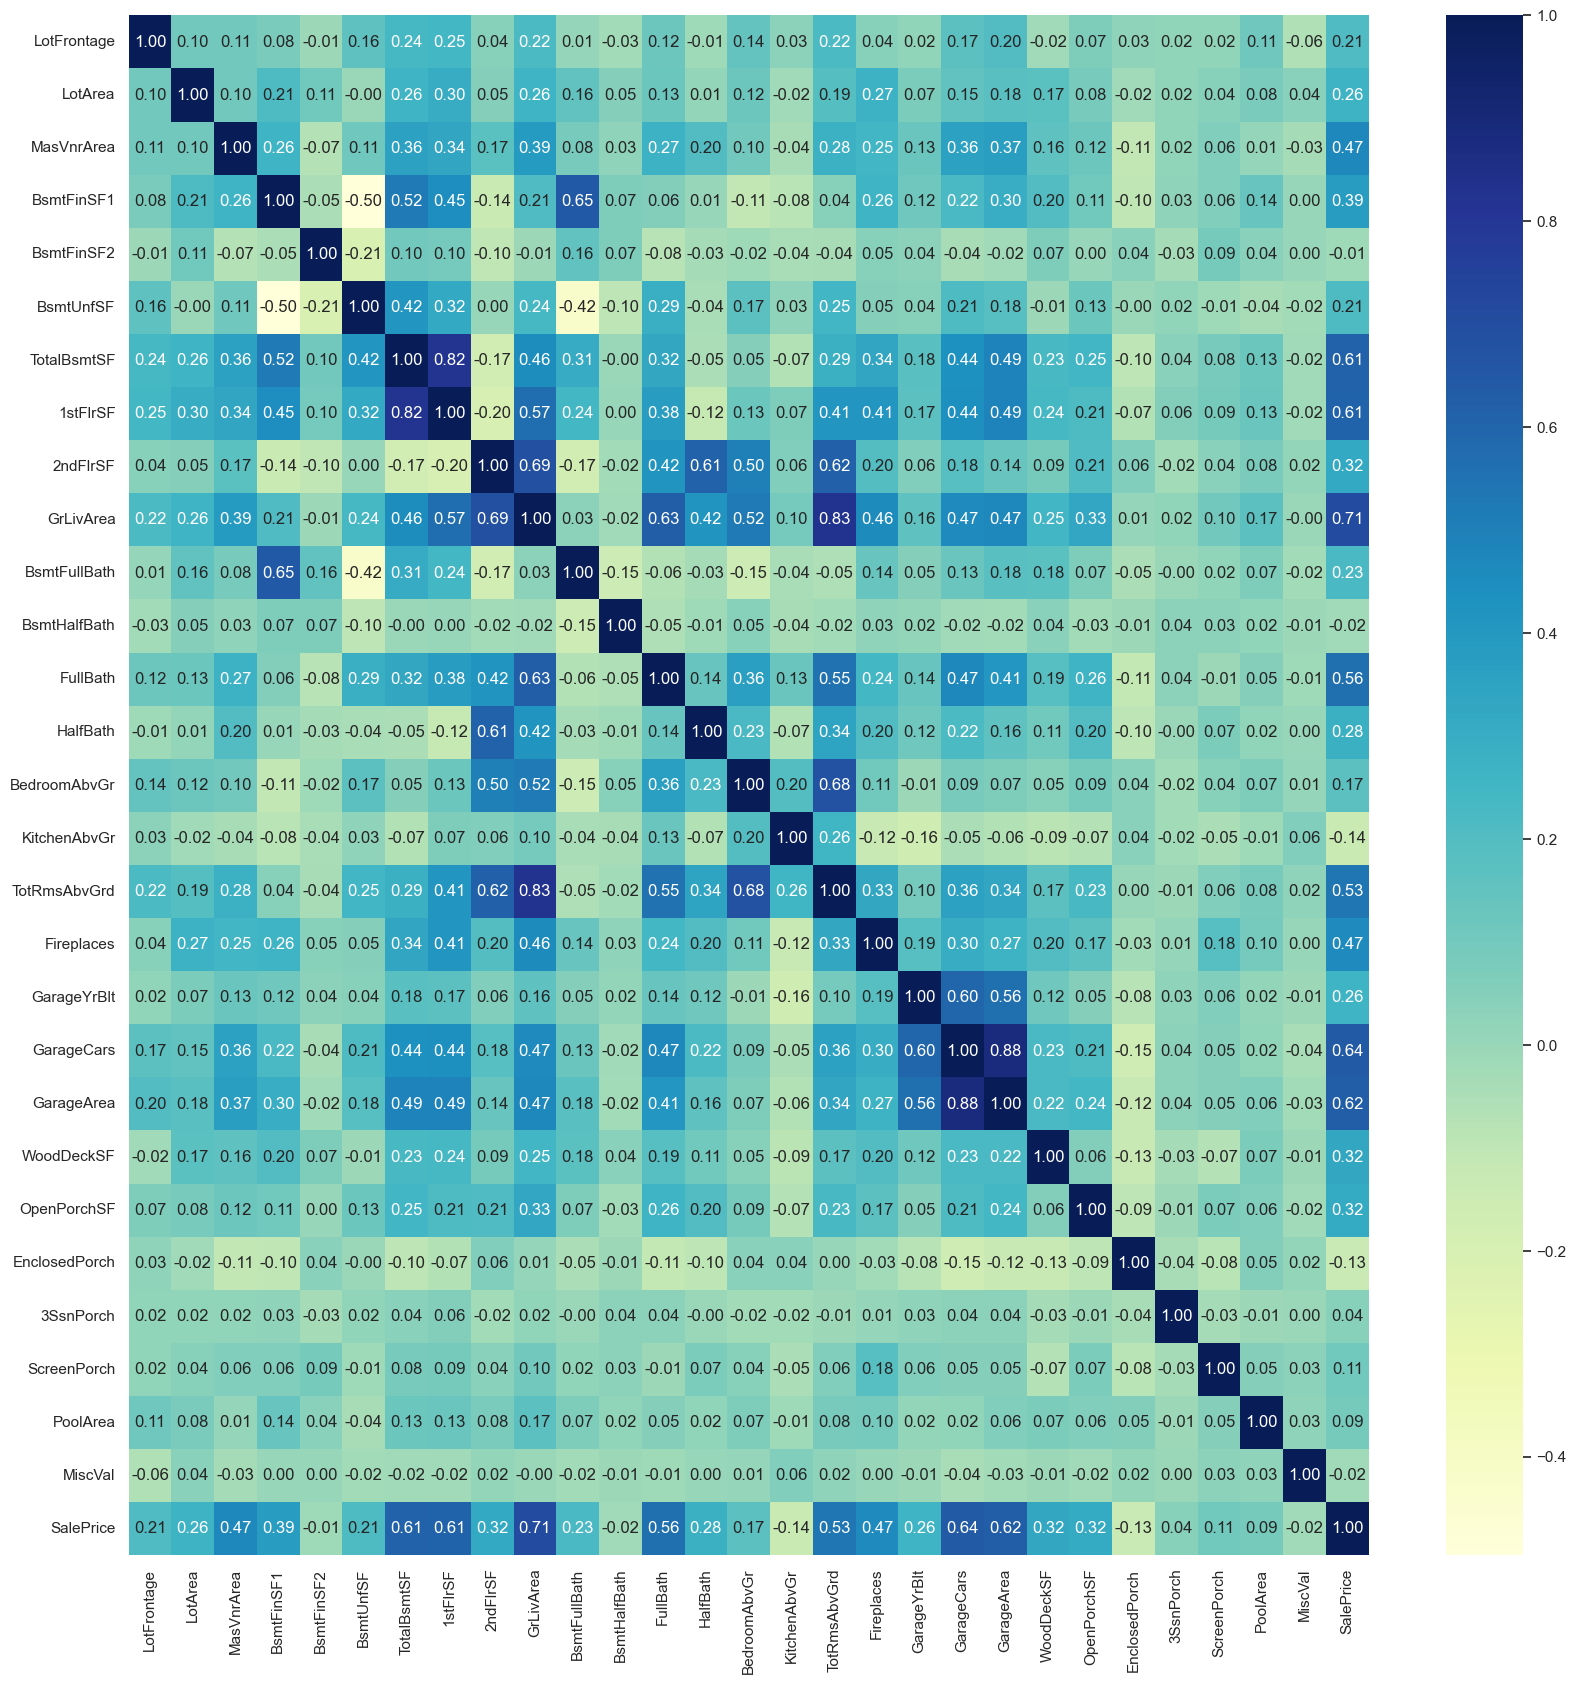

In [401]:
# plotting correlations on a heatmap
plt.figure(figsize=(20, 20))

# Create a heatmap using seaborn
sns.heatmap(cor, annot=True, cmap='YlGnBu', fmt=".2f")

# Show the plot
plt.show()

### Observation/s

- When we look at SalePrice we can observe that
    - SalePrice is highly correlated to GrLivArea, MasVnrArea, TotalBsmtSF, 1stFlrSF etc.
- We can also observe that there is also multi collinearity between variables. 

Note : We will be using Lasso method for regularization to take care of multicollinearity

### Encoding: Convert categorical variables in to dummy Variables


In [402]:
# encoding Month for MoSold
codes = {10:'Very Excellent', 9:'Excellent', 8:'Very Good',7:'Good',6:'Above Average',5:'Average',4:'Below Average',3:'Fair',2:'Poor',1:'Very Poor'}
aus_house_df['MoSold'] = aus_house_df['MoSold'].map(codes)

# encoding OverallCond
codes = {10:'Very Excellent', 9:'Excellent', 8:'Very Good',7:'Good',6:'Above Average',5:'Average',4:'Below Average',3:'Fair',2:'Poor',1:'Very Poor'}
aus_house_df['OverallCond'] = aus_house_df['OverallCond'].map(codes)

In [403]:
# Let's get dummy variables and drop the first column from dummy_var df using 'drop_first = True'
dummy_var = pd.get_dummies(aus_house_df[categorical_columns], drop_first = True)
dummy_var.head(5)

GarageYrBlt  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  \
0       2003.0              0              0              0              0   
1       1976.0              0              0              0              0   
2       2001.0              0              0              0              0   
3       1998.0              0              0              0              0   
4       2000.0              0              0              0              0   

   MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  \
0              1              0              0              0              0   
1              0              0              0              0              0   
2              1              0              0              0              0   
3              0              1              0              0              0   
4              1              0              0              0              0   

   ...  YearRemodAdd_2010  MoSold_Average  MoSold_Below Average  \
0  ...                  0               0                     0   
1  ...                  0               1                     0   
2  ...                  0               0                     0   
3  ...                  0               0                     0   
4  ...                  0               0                     0   

   MoSold_Excellent  MoSold_Fair  MoSold_Good  MoSold_Poor  \
0                 0            0            0            1   
1                 0            0            0            0   
2                 1            0            0            0   
3                 0            0            0            1   
4                 0            0            0            0   

   MoSold_Very Excellent  MoSold_Very Good  MoSold_Very Poor  
0                      0                 0                 0  
1                      0                 0                 0  
2                      0                 0                 0  
3                      0                 0                 0  
4                      0                 0                 0  

[5 rows x 422 columns]

In [404]:
# Add the results to the original housing dataframe
aus_house_df = pd.concat([aus_house_df, dummy_var], axis = 1)

# Drop categorical_col as we have created the dummies for it
aus_house_df.drop(categorical_columns, axis = 1, inplace = True)


# Model Building : Data Preparation for model building

Let's now prepare the data and build the model.

In [405]:
# split into X and y
y = aus_house_df.pop('SalePrice')
X = aus_house_df

In [406]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       ...
       'YearRemodAdd_2010', 'MoSold_Average', 'MoSold_Below Average',
       'MoSold_Excellent', 'MoSold_Fair', 'MoSold_Good', 'MoSold_Poor',
       'MoSold_Very Excellent', 'MoSold_Very Good', 'MoSold_Very Poor'],
      dtype='object', length=447)

In [407]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## Ridge and Lasso Regression

Let's now try ridge and lasso regression.

## Ridge Regression

In [408]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100,300,400, 500,600,700,1000, 1100, 1200, 1300, 2000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 300, 400, 500, 600, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [409]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [410]:
#Fitting Ridge model for alpha = 600 and printing coefficients which have been penalised
alpha = 500
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ 7.59941740e+02  2.80509112e+03  3.79662263e+03  2.52548268e+03
  9.08381109e+02  4.14279864e+02  3.37874470e+03  5.00293872e+03
  4.22749621e+03  7.06877009e+03  2.43035795e+03  1.65504745e+02
  4.29767601e+03  1.76206354e+03  5.29624264e+02 -1.61651097e+03
  4.41946017e+03  2.70101525e+03  5.74422710e+03  1.59899608e+03
  6.80503257e+02  4.53195579e+02  1.08984089e+03  1.42048170e+03
 -9.07243909e+02  1.20878137e+02 -9.12580459e+02 -6.47983363e+01
  2.01128158e+02 -2.41569104e+02  1.00869120e+03  6.74735013e+02
  5.23271896e+01 -6.78085447e+02 -1.78308406e+02 -7.23524504e+02
 -1.28939803e+03 -1.41998055e+03 -5.76739602e+02 -9.95385184e+02
  1.08178526e+03  3.99945153e+02  1.28318757e+03 -1.14069903e+03
  1.06016631e+03  3.27341259e+02 -2.31996140e+03 -3.38637578e+02
  1.61291775e+03  8.42530299e+02  1.20088332e+03 -8.11860597e+02
  1.88452539e+03 -9.92424157e+02 -8.34985146e+02 -6.48805332e+02
  4.80727979e+02  1.14095683e+02 -9.28727568e+01 -2.23895325e+02
 -1.60215837e+02  4.15880

In [411]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8996469441261953
0.8627221063064067
680199115291.5326
332777805827.04443
666208731.9211876
759766679.9704211


## Lasso

In [412]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 300, 400, 500, 600, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [413]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 1100}


In [414]:
#Fitting Lasso model for alpha = 1100 and printing coefficients which have been penalised

alpha =1100

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=1100)

In [415]:
lasso.coef_

array([ 0.00000000e+00,  2.94445563e+03,  1.73759484e+03,  7.19212270e+02,
        0.00000000e+00, -0.00000000e+00,  2.12889966e+03,  0.00000000e+00,
        0.00000000e+00,  2.49209165e+04,  3.06383138e+03,  0.00000000e+00,
        3.92607444e+03,  1.98082716e+02, -0.00000000e+00, -4.45416607e+03,
        0.00000000e+00,  1.72332564e+03,  9.61563966e+03,  3.49547043e+02,
        0.00000000e+00, -0.00000000e+00,  4.76470126e+02,  9.06153047e+02,
       -2.95158536e+03,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -5.70740239e+02, -0.00000000e+00, -3.36189062e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.57415966e+03,
        8.84627015e+02,  0.00000000e+00, -1.73203673e+03, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.93849511e+02, -3.26185708e+02,
        2.15956835e+03, -

In [416]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8932448576445613
0.8628213155367553
723592846781.9163
332537310951.24963
708709938.0821903
759217604.9115288


In [417]:
# Creating a table which contain all the metrics

rg_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Ridge Regression': metric2
        }

rg_metric = pd.DataFrame(rg_table ,columns = ['Metric', 'Ridge Regression'] )

ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([rg_metric, ls_metric], axis = 1)

final_metric

Metric  Ridge Regression  Lasso Regression
0  R2 Score (Train)      8.996469e-01      8.932449e-01
1   R2 Score (Test)      8.627221e-01      8.628213e-01
2       RSS (Train)      6.801991e+11      7.235928e+11
3        RSS (Test)      3.327778e+11      3.325373e+11
4       MSE (Train)      2.581102e+04      2.662161e+04
5        MSE (Test)      2.756387e+04      2.755390e+04

## Lets observe the changes in the coefficients after regularization

In [418]:
# DataFrame Initialization
betas = pd.DataFrame(index=X.columns)
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

# Sort by Lasso Coefficients
betas.sort_values(by='Lasso', ascending=False, inplace=True)

# Display the Results
pd.set_option('display.max_rows', None)
print(betas.head(68))

                             Ridge         Lasso
GrLivArea              7068.770085  24920.916490
OverallQual_9          6947.658965  13321.842265
OverallQual_10         7025.585927  12425.540450
GarageCars             5744.227104   9615.639660
OverallQual_8          3328.503271   9105.895766
Neighborhood_NridgHt   5797.545657   6680.739387
Neighborhood_NoRidge   5478.928873   6092.675666
BsmtExposure_Gd        4286.753231   5261.195795
RoofMatl_WdShngl       4940.136618   5146.349344
SaleType_New           1592.450387   4611.439606
Neighborhood_Crawfor   2733.580629   3962.644007
FullBath               4297.676010   3926.074437
YearRemodAdd_2010      2968.939383   3758.345139
BsmtFullBath           2430.357947   3063.831383
BsmtFinType1_GLQ       2966.483511   3048.273789
LotArea                2805.091124   2944.455631
YearBuilt_1996         2288.580747   2792.073312
OverallQual_7          -300.271944   2491.758070
Functional_Typ         1376.588471   2399.087802
RoofMatl_CompShg    

# Conclusion


#### Which variables are significant in predicting the price of a house ?
- The top five significant variables to predict the price of a house are 
    - GrLivArea :        
    - Overall Quality more than 9
        - OverallQual_9
        - OverallQual_10
    - GarageCars
    - OverallQual_8
    - Neighborhood type 
        - Neighborhood_NridgHt
        - Neighborhood_NoRidge
        
#### How well those variables describe the price of a house ?

- From the R2 Score we can infer that the model can explain upto 89% variance

#### When the market value of the property goes lower than the Predicted Sale Price one can buy the property to book profit. 